In [1]:
!pip install torchinfo

In [2]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_auc_score, roc_curve, auc)
import matplotlib.pyplot as plt

In [3]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


In [4]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [5]:
data_dir = "/kaggle/input/Fish Data raw/Fish Data"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

Class: Rui, Count: 2500
Class: Taki, Count: 2223
Class: Telapiya, Count: 2058
Class: Mrigel, Count: 1808
Class: Aair, Count: 1804
Class: Katla, Count: 1765
Class: Pabda, Count: 1764
Class: Boal, Count: 1651
Class: Puti, Count: 1560
Class: Tengra, Count: 1431
Class: Shol, Count: 1424
Class: Tarabaim, Count: 1262
Class: Ilish, Count: 1031
Class: Pangas, Count: 934
Class: KalBaush, Count: 917
Class: Koi, Count: 842
Class: Magur, Count: 574
Class: Foli, Count: 562
Class: Chapila, Count: 428
Class: DeshiPuti, Count: 412


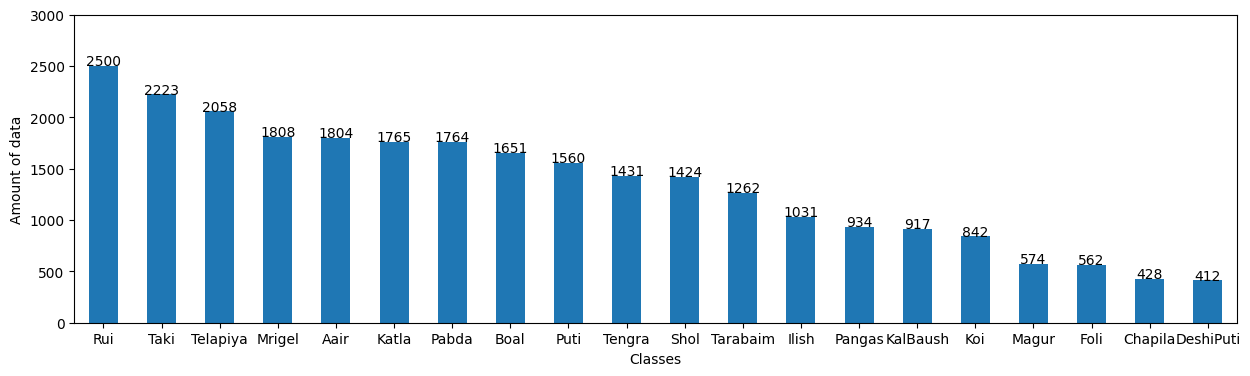

In [6]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(15, 4))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

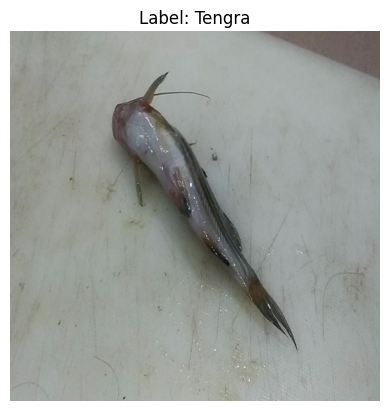

In [7]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [8]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, 
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, 
                                            stratify=temp_dataframe['label'], random_state=42)

In [9]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  18865
Validation Data:  4042
Test Data:  4043
-------------------------------------------
Total amounts of data in the dataset:  26950


In [10]:
class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class        Count
---------  -------
Rui           1750
Taki          1556
Telapiya      1441
Mrigel        1265
Aair          1263
Pabda         1235
Katla         1235
Boal          1156
Puti          1092
Tengra        1002
Shol           997
Tarabaim       883
Ilish          722
Pangas         654
KalBaush       642
Koi            589
Magur          402
Foli           393
Chapila        300
DeshiPuti      288

Validation Dataset
Class        Count
---------  -------
Rui            375
Taki           333
Telapiya       308
Mrigel         271
Aair           270
Katla          265
Pabda          264
Boal           247
Puti           234
Shol           214
Tengra         214
Tarabaim       190
Ilish          155
Pangas         140
KalBaush       138
Koi            127
Magur           86
Foli            85
Chapila         64
DeshiPuti       62

Test Dataset
Class        Count
---------  -------
Rui            375
Taki           334
Telapiya       309
Mrigel         272
Aa

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        class_names = sorted(self.dataframe['label'].unique())  # Ensure consistent order
        self.label_map = {class_name: idx for idx, class_name in enumerate(class_names)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [13]:
normalize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = ImageDataset(train_dataframe, normalize, is_lb=True)
print(train_dataset.label_map)

{'Aair': 0, 'Boal': 1, 'Chapila': 2, 'DeshiPuti': 3, 'Foli': 4, 'Ilish': 5, 'KalBaush': 6, 'Katla': 7, 'Koi': 8, 'Magur': 9, 'Mrigel': 10, 'Pabda': 11, 'Pangas': 12, 'Puti': 13, 'Rui': 14, 'Shol': 15, 'Taki': 16, 'Tarabaim': 17, 'Telapiya': 18, 'Tengra': 19}


In [14]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

In [15]:
train_batch = 32
val_batch = 8

def data_transfrom():
    normalize = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor()])

    train_dataset = ImageDataset (
        train_dataframe,
        normalize,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

# Attention blocks

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Squeeze-and-Excitation Block
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Channel Attention Module (part of CBAM)
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

# Spatial Attention Module (part of CBAM)
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

# CBAM (Convolutional Block Attention Module)
class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.ca(x) * x
        x = self.sa(x) * x
        return x

# Self-Attention Module
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        m_batchsize, C, width, height = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width*height)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, width, height)
        out = self.gamma * out + x
        return out

# GCNet Attention (Global Context Block)
class GCBlock(nn.Module):
    def __init__(self, in_channels, ratio=16):
        super(GCBlock, self).__init__()
        self.pool_h = nn.AdaptiveAvgPool2d((None, 1))
        self.pool_w = nn.AdaptiveAvgPool2d((1, None))
        
        mip = max(8, in_channels // ratio)
        
        self.conv1 = nn.Conv2d(in_channels, mip, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(mip)
        self.act = nn.ReLU(inplace=True)
        
        self.conv_h = nn.Conv2d(mip, in_channels, kernel_size=1, stride=1, padding=0)
        self.conv_w = nn.Conv2d(mip, in_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        identity = x
        
        n, c, h, w = x.size()
        x_h = self.pool_h(x)
        x_w = self.pool_w(x).permute(0, 1, 3, 2)
        
        y = torch.cat([x_h, x_w], dim=2)
        y = self.conv1(y)
        y = self.bn1(y)
        y = self.act(y)
        
        x_h, x_w = torch.split(y, [h, w], dim=2)
        x_w = x_w.permute(0, 1, 3, 2)
        
        a_h = self.conv_h(x_h).sigmoid()
        a_w = self.conv_w(x_w).sigmoid()
        
        out = identity * a_w * a_h
        return out



In [17]:
# Enhanced FishNet with Attention Mechanisms
class FishNetWithAttention(nn.Module):
    def __init__(self, num_classes, attention_type='cbam'):
        super(FishNetWithAttention, self).__init__()
        self.attention_type = attention_type
        
        # Feature extraction layers
        self.features = nn.Sequential()
        
        # First block
        self.features.add_module('conv1', nn.Conv2d(3, 32, 3, padding=1))
        self.features.add_module('bn1', nn.BatchNorm2d(32))
        self.features.add_module('relu1', nn.ReLU())
        self.features.add_module('pool1', nn.MaxPool2d(2, 2))
        
        # Add attention after first block
        if attention_type == 'se':
            self.features.add_module('se1', SEBlock(32))
        elif attention_type == 'cbam':
            self.features.add_module('cbam1', CBAM(32))
        elif attention_type == 'self':
            self.features.add_module('self1', SelfAttention(32))
        elif attention_type == 'gc':
            self.features.add_module('gc1', GCBlock(32))
        
        # Second block
        self.features.add_module('conv2', nn.Conv2d(32, 64, 3, padding=1))
        self.features.add_module('bn2', nn.BatchNorm2d(64))
        self.features.add_module('relu2', nn.ReLU())
        self.features.add_module('pool2', nn.MaxPool2d(2, 2))
        
        # Add attention after second block
        if attention_type == 'se':
            self.features.add_module('se2', SEBlock(64))
        elif attention_type == 'cbam':
            self.features.add_module('cbam2', CBAM(64))
        elif attention_type == 'self':
            self.features.add_module('self2', SelfAttention(64))
        elif attention_type == 'gc':
            self.features.add_module('gc2', GCBlock(64))
        
        # Third block
        self.features.add_module('conv3', nn.Conv2d(64, 128, 3, padding=1))
        self.features.add_module('bn3', nn.BatchNorm2d(128))
        self.features.add_module('relu3', nn.ReLU())
        self.features.add_module('pool3', nn.MaxPool2d(2, 2))
        
        # Add attention after third block
        if attention_type == 'se':
            self.features.add_module('se3', SEBlock(128))
        elif attention_type == 'cbam':
            self.features.add_module('cbam3', CBAM(128))
        elif attention_type == 'self':
            self.features.add_module('self3', SelfAttention(128))
        elif attention_type == 'gc':
            self.features.add_module('gc3', GCBlock(128))
        
        # Fourth block
        self.features.add_module('conv4', nn.Conv2d(128, 256, 3, padding=1))
        self.features.add_module('bn4', nn.BatchNorm2d(256))
        self.features.add_module('relu4', nn.ReLU())
        self.features.add_module('pool4', nn.MaxPool2d(2, 2))
        
        # Add attention after fourth block
        if attention_type == 'se':
            self.features.add_module('se4', SEBlock(256))
        elif attention_type == 'cbam':
            self.features.add_module('cbam4', CBAM(256))
        elif attention_type == 'self':
            self.features.add_module('self4', SelfAttention(256))
        elif attention_type == 'gc':
            self.features.add_module('gc4', GCBlock(256))
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [18]:
# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=120, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    best_val_acc = 0.0

    # Make sure checkpoint directory exists
    import os
    os.makedirs(save_path_checkpoints, exist_ok=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total

        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for val_images, val_labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)

                val_loss += loss.item() * val_images.size(0)
                _, val_preds = torch.max(val_outputs, 1)
                val_correct += (val_preds == val_labels).sum().item()
                val_total += val_labels.size(0)

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total

        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        # Save checkpoint if improved
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save({
                'epoch': epoch,
                'model_weight': model.state_dict(),
                'optimizer_state': optimizer.state_dict()
            }, f"{save_path_checkpoints}/model.pt")

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

    print(f"Best Validation Accuracy: {best_val_acc:.4f}")

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


In [19]:
# Evaluation function
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

# Class accuracy function
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

# Feature extraction function
def extract_features(extractor, data_loader, device):
    extractor.eval()
    features_list = []
    labels_list = []
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Extracting Features"):
            images = images.to(device)
            feats = extractor(images)  # Shape: [batch, 256]
            features_list.append(feats.cpu().numpy())
            labels_list.append(labels.numpy())
    return np.concatenate(features_list, axis=0), np.concatenate(labels_list, axis=0)

# Function to create different attention-based models
def create_attention_model(num_classes, attention_type):
    return FishNetWithAttention(num_classes, attention_type).to(device)

# Feature extractor for attention models
def create_feature_extractor_with_attention(original_model):
    class FishNetFeaturesWithAttention(nn.Module):
        def __init__(self, original_model):
            super(FishNetFeaturesWithAttention, self).__init__()
            # Extract feature layers
            self.features = original_model.features
            # Extract classifier layers up to 256-D features
            self.classifier_part = nn.Sequential(*list(original_model.classifier.children())[:-3])
        
        def forward(self, x):
            x = self.features(x)
            x = self.classifier_part(x)
            return x
    
    return FishNetFeaturesWithAttention(original_model).to(device)


In [20]:
# Now let's run the attention-based models
attention_types = ['se', 'cbam' , 'gc']
attention_results = {}

print("Starting Attention-Based Model Training...")

# Train and evaluate each attention-based model
for attention_type in attention_types:
    print(f"\n{'='*50}")
    print(f"Training FishNet with {attention_type.upper()} Attention")
    print(f"{'='*50}")
    
    # Create model
    model_attn = create_attention_model(num_classes=20, attention_type=attention_type)
    
    # Define loss and optimizer
    criterion_attn = nn.CrossEntropyLoss()
    optimizer_attn = torch.optim.Adam(model_attn.parameters(), lr=0.0001)
    
    # Train the model
    start_time = time.time()
    train_loss_history_attn, train_acc_history_attn, val_loss_history_attn, val_acc_history_attn = train_model(
        model_attn, criterion_attn, optimizer_attn,
        dataloader_train_dataset, dataloader_valid_dataset,
        num_epochs=120,
        save_path_checkpoints=f"checkpoints_{attention_type}"
    )
    training_time_attn = time.time() - start_time
    
    # Save training history
    data_attn = {
        'Epoch': list(range(1, len(train_loss_history_attn) + 1)),
        'Train Loss': train_loss_history_attn,
        'Train Accuracy': train_acc_history_attn,
        'Validation Loss': val_loss_history_attn,
        'Validation Accuracy': val_acc_history_attn
    }
    history_attn = pd.DataFrame(data_attn)
    history_attn.to_excel(f'/kaggle/working/training_data_{attention_type}.xlsx', index=False)
    
    # Load best model
    checkpoint_path_attn = f"checkpoints_{attention_type}/model.pt"
    checkpoint_attn = torch.load(checkpoint_path_attn, map_location=device)
    model_attn.load_state_dict(checkpoint_attn['model_weight'])
    model_attn.eval()
    
    # Evaluate on test set
    start_time = time.time()
    test_loss_attn, test_accuracy_attn = evaluate_model(model_attn, criterion_attn, dataloader_test_dataset)
    test_time_attn = time.time() - start_time
    
    print(f"Test Accuracy for {attention_type.upper()}: {test_accuracy_attn:.4f}")
    print(f"Training Time: {training_time_attn/60:.2f} minutes")
    print(f"Test Time: {test_time_attn:.2f} seconds")
    
    # Store results
    attention_results[attention_type] = {
        'model': model_attn,
        'test_accuracy': test_accuracy_attn,
        'training_time': training_time_attn,
        'test_time': test_time_attn,
        'checkpoint_path': checkpoint_path_attn
    }

# Extract features and apply ML classifiers for each attention model
ml_results_attention = {}

for attention_type in attention_types:
    print(f"\nProcessing {attention_type.upper()} Attention Model for ML Classifiers...")
    
    # Load best model
    model_attn = attention_results[attention_type]['model']
    
    # Create feature extractor
    feature_extractor_attn = create_feature_extractor_with_attention(model_attn)
    feature_extractor_attn.eval()
    
    # Extract features
    X_train_feats_attn, y_train_attn = extract_features(feature_extractor_attn, dataloader_train_dataset, device)
    X_test_feats_attn, y_test_attn = extract_features(feature_extractor_attn, dataloader_test_dataset, device)
    
    # Scale features
    scaler_attn = StandardScaler()
    X_train_scaled_attn = scaler_attn.fit_transform(X_train_feats_attn)
    X_test_scaled_attn = scaler_attn.transform(X_test_feats_attn)
    
    # Train ML classifiers
    classifiers_attn = {
        "SVM": SVC(kernel='rbf', probability=True, random_state=42),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        "XGBoost": XGBClassifier(n_estimators=100, eval_metric='mlogloss', random_state=42, n_jobs=-1)
    }
    
    results_attn = []
    y_pred_dict_attn = {}
    y_proba_dict_attn = {}
    
    for name, clf in classifiers_attn.items():
        print(f"  Training {name}...")
        start = time.time()
        
        # Fit
        if name == "SVM":
            clf.fit(X_train_feats_attn, y_train_attn)
            train_time = time.time() - start
            
            # Predict
            pred_start = time.time()
            y_pred = clf.predict(X_test_feats_attn)
            y_proba = clf.predict_proba(X_test_feats_attn)
            test_time = time.time() - pred_start
        else:
            clf.fit(X_train_scaled_attn, y_train_attn)
            train_time = time.time() - start
            
            # Predict
            pred_start = time.time()
            y_pred = clf.predict(X_test_scaled_attn)
            y_proba = clf.predict_proba(X_test_scaled_attn)
            test_time = time.time() - pred_start

        # Metrics
        acc = accuracy_score(y_test_attn, y_pred)
        prec = precision_score(y_test_attn, y_pred, average='weighted')
        rec = recall_score(y_test_attn, y_pred, average='weighted')
        f1 = f1_score(y_test_attn, y_pred, average='weighted')
        
        try:
            auc_score = roc_auc_score(y_test_attn, y_proba, average='weighted', multi_class='ovr') if y_proba.shape[1] > 2 else roc_auc_score(y_test_attn, y_proba[:, 1])
        except:
            auc_score = float('nan')

        # Store results
        results_attn.append({
            "Model": f"{attention_type.upper()}+{name}",
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1,
            "ROC-AUC": auc_score,
            "Train Time (s)": train_time,
            "Test Time (s)": test_time
        })
        y_pred_dict_attn[name] = y_pred
        y_proba_dict_attn[name] = y_proba
    
    # Store results for this attention type
    ml_results_attention[attention_type] = pd.DataFrame(results_attn)

print("Attention-based models training and evaluation completed!")
print("Now creating comprehensive comparison results...")

# Create comprehensive comparison results
print("\n" + "="*80)
print("COMPREHENSIVE RESULTS COMPARISON")
print("="*80)

# Combine all results
all_results = []

# Add baseline CNN results (from your previous results)
baseline_cnn_result = {
    "Model": "Baseline CNN",
    "Accuracy": 0.9785,
    "Precision": 0.9789,
    "Recall": 0.9785,
    "F1-Score": 0.9785,
    "ROC-AUC": 0.9996,
    "Train Time (s)": "N/A",
    "Test Time (s)": "N/A"
}
all_results.append(baseline_cnn_result)

# Add hybrid CNN+ML results (from your previous results)
# Assuming you have results_df from your previous code
try:
    for _, row in results_df.iterrows():
        all_results.append(row.to_dict())
except:
    print("Previous ML results not available, skipping...")

# Add attention-based results
for attention_type in attention_types:
    # Add attention-only CNN results
    attn_cnn_result = {
        "Model": f"{attention_type.upper()} CNN",
        "Accuracy": attention_results[attention_type]['test_accuracy'],
        "Precision": "N/A",
        "Recall": "N/A",
        "F1-Score": "N/A",
        "ROC-AUC": "N/A",
        "Train Time (s)": attention_results[attention_type]['training_time'],
        "Test Time (s)": attention_results[attention_type]['test_time']
    }
    all_results.append(attn_cnn_result)
    
    # Add hybrid attention+ML results
    for _, row in ml_results_attention[attention_type].iterrows():
        all_results.append(row.to_dict())


Starting Attention-Based Model Training...

Training FishNet with SE Attention


Epoch 1/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 1/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 1/120 | Train Loss: 1.6706 | Train Acc: 0.4593 | Val Loss: 0.7724 | Val Acc: 0.7412


Epoch 2/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 2/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 2/120 | Train Loss: 0.6884 | Train Acc: 0.7765 | Val Loss: 0.4570 | Val Acc: 0.8439


Epoch 3/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 3/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 3/120 | Train Loss: 0.4189 | Train Acc: 0.8655 | Val Loss: 0.2361 | Val Acc: 0.9231


Epoch 4/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 4/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 4/120 | Train Loss: 0.2984 | Train Acc: 0.9043 | Val Loss: 0.1680 | Val Acc: 0.9463


Epoch 5/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 5/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 5/120 | Train Loss: 0.2270 | Train Acc: 0.9245 | Val Loss: 0.1490 | Val Acc: 0.9510


Epoch 6/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 6/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 6/120 | Train Loss: 0.1769 | Train Acc: 0.9423 | Val Loss: 0.1071 | Val Acc: 0.9666


Epoch 7/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 7/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 7/120 | Train Loss: 0.1538 | Train Acc: 0.9484 | Val Loss: 0.1067 | Val Acc: 0.9668


Epoch 8/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 8/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 8/120 | Train Loss: 0.1265 | Train Acc: 0.9577 | Val Loss: 0.0864 | Val Acc: 0.9718


Epoch 9/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 9/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 9/120 | Train Loss: 0.1109 | Train Acc: 0.9631 | Val Loss: 0.0749 | Val Acc: 0.9775


Epoch 10/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 10/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 10/120 | Train Loss: 0.0992 | Train Acc: 0.9677 | Val Loss: 0.0819 | Val Acc: 0.9755


Epoch 11/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 11/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 11/120 | Train Loss: 0.0851 | Train Acc: 0.9721 | Val Loss: 0.0642 | Val Acc: 0.9795


Epoch 12/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 12/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 12/120 | Train Loss: 0.0879 | Train Acc: 0.9722 | Val Loss: 0.0622 | Val Acc: 0.9777


Epoch 13/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 13/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 13/120 | Train Loss: 0.0735 | Train Acc: 0.9758 | Val Loss: 0.0689 | Val Acc: 0.9775


Epoch 14/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 14/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 14/120 | Train Loss: 0.0705 | Train Acc: 0.9767 | Val Loss: 0.0734 | Val Acc: 0.9758


Epoch 15/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 15/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 15/120 | Train Loss: 0.0539 | Train Acc: 0.9809 | Val Loss: 0.0689 | Val Acc: 0.9777


Epoch 16/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 16/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 16/120 | Train Loss: 0.0521 | Train Acc: 0.9822 | Val Loss: 0.1262 | Val Acc: 0.9691


Epoch 17/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 17/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 17/120 | Train Loss: 0.0549 | Train Acc: 0.9823 | Val Loss: 0.1275 | Val Acc: 0.9634


Epoch 18/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 18/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 18/120 | Train Loss: 0.0516 | Train Acc: 0.9840 | Val Loss: 0.1038 | Val Acc: 0.9735


Epoch 19/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 19/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 19/120 | Train Loss: 0.0506 | Train Acc: 0.9824 | Val Loss: 0.0610 | Val Acc: 0.9817


Epoch 20/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 20/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 20/120 | Train Loss: 0.0477 | Train Acc: 0.9851 | Val Loss: 0.1046 | Val Acc: 0.9683


Epoch 21/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 21/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 21/120 | Train Loss: 0.0410 | Train Acc: 0.9866 | Val Loss: 0.0487 | Val Acc: 0.9837


Epoch 22/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 22/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 22/120 | Train Loss: 0.0360 | Train Acc: 0.9878 | Val Loss: 0.0574 | Val Acc: 0.9839


Epoch 23/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 23/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 23/120 | Train Loss: 0.0402 | Train Acc: 0.9865 | Val Loss: 0.0558 | Val Acc: 0.9837


Epoch 24/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 24/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 24/120 | Train Loss: 0.0440 | Train Acc: 0.9863 | Val Loss: 0.0525 | Val Acc: 0.9854


Epoch 25/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 25/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 25/120 | Train Loss: 0.0349 | Train Acc: 0.9886 | Val Loss: 0.0517 | Val Acc: 0.9839


Epoch 26/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 26/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 26/120 | Train Loss: 0.0314 | Train Acc: 0.9897 | Val Loss: 0.0797 | Val Acc: 0.9758


Epoch 27/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 27/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 27/120 | Train Loss: 0.0391 | Train Acc: 0.9873 | Val Loss: 0.0531 | Val Acc: 0.9839


Epoch 28/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 28/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 28/120 | Train Loss: 0.0335 | Train Acc: 0.9883 | Val Loss: 0.1084 | Val Acc: 0.9738


Epoch 29/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 29/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 29/120 | Train Loss: 0.0341 | Train Acc: 0.9894 | Val Loss: 0.0503 | Val Acc: 0.9854


Epoch 30/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 30/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 30/120 | Train Loss: 0.0328 | Train Acc: 0.9902 | Val Loss: 0.0396 | Val Acc: 0.9889


Epoch 31/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 31/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 31/120 | Train Loss: 0.0239 | Train Acc: 0.9914 | Val Loss: 0.0569 | Val Acc: 0.9839


Epoch 32/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 32/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 32/120 | Train Loss: 0.0337 | Train Acc: 0.9886 | Val Loss: 0.0729 | Val Acc: 0.9814


Epoch 33/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 33/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 33/120 | Train Loss: 0.0263 | Train Acc: 0.9911 | Val Loss: 0.0526 | Val Acc: 0.9854


Epoch 34/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 34/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 34/120 | Train Loss: 0.0313 | Train Acc: 0.9897 | Val Loss: 0.0816 | Val Acc: 0.9782


Epoch 35/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 35/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 35/120 | Train Loss: 0.0226 | Train Acc: 0.9923 | Val Loss: 0.0560 | Val Acc: 0.9837


Epoch 36/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 36/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 36/120 | Train Loss: 0.0301 | Train Acc: 0.9904 | Val Loss: 0.0766 | Val Acc: 0.9805


Epoch 37/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 37/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 37/120 | Train Loss: 0.0256 | Train Acc: 0.9922 | Val Loss: 0.0686 | Val Acc: 0.9832


Epoch 38/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 38/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 38/120 | Train Loss: 0.0249 | Train Acc: 0.9919 | Val Loss: 0.0584 | Val Acc: 0.9852


Epoch 39/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 39/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 39/120 | Train Loss: 0.0300 | Train Acc: 0.9919 | Val Loss: 0.0582 | Val Acc: 0.9852


Epoch 40/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 40/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 40/120 | Train Loss: 0.0201 | Train Acc: 0.9932 | Val Loss: 0.0341 | Val Acc: 0.9906


Epoch 41/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 41/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 41/120 | Train Loss: 0.0184 | Train Acc: 0.9939 | Val Loss: 0.0803 | Val Acc: 0.9792


Epoch 42/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 42/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 42/120 | Train Loss: 0.0203 | Train Acc: 0.9936 | Val Loss: 0.0779 | Val Acc: 0.9827


Epoch 43/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 43/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 43/120 | Train Loss: 0.0195 | Train Acc: 0.9939 | Val Loss: 0.0533 | Val Acc: 0.9859


Epoch 44/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 44/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 44/120 | Train Loss: 0.0228 | Train Acc: 0.9926 | Val Loss: 0.0714 | Val Acc: 0.9844


Epoch 45/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 45/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 45/120 | Train Loss: 0.0206 | Train Acc: 0.9935 | Val Loss: 0.0496 | Val Acc: 0.9871


Epoch 46/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 46/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 46/120 | Train Loss: 0.0161 | Train Acc: 0.9951 | Val Loss: 0.0610 | Val Acc: 0.9866


Epoch 47/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 47/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 47/120 | Train Loss: 0.0257 | Train Acc: 0.9919 | Val Loss: 0.0539 | Val Acc: 0.9871


Epoch 48/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 48/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 48/120 | Train Loss: 0.0172 | Train Acc: 0.9944 | Val Loss: 0.0474 | Val Acc: 0.9889


Epoch 49/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 49/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 49/120 | Train Loss: 0.0210 | Train Acc: 0.9939 | Val Loss: 0.0564 | Val Acc: 0.9857


Epoch 50/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 50/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 50/120 | Train Loss: 0.0185 | Train Acc: 0.9929 | Val Loss: 0.0700 | Val Acc: 0.9834


Epoch 51/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 51/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 51/120 | Train Loss: 0.0190 | Train Acc: 0.9939 | Val Loss: 0.1018 | Val Acc: 0.9748


Epoch 52/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 52/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 52/120 | Train Loss: 0.0138 | Train Acc: 0.9951 | Val Loss: 0.0412 | Val Acc: 0.9906


Epoch 53/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 53/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 53/120 | Train Loss: 0.0181 | Train Acc: 0.9944 | Val Loss: 0.0529 | Val Acc: 0.9857


Epoch 54/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 54/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 54/120 | Train Loss: 0.0185 | Train Acc: 0.9941 | Val Loss: 0.0394 | Val Acc: 0.9896


Epoch 55/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 55/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 55/120 | Train Loss: 0.0167 | Train Acc: 0.9946 | Val Loss: 0.0567 | Val Acc: 0.9866


Epoch 56/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 56/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 56/120 | Train Loss: 0.0138 | Train Acc: 0.9960 | Val Loss: 0.0939 | Val Acc: 0.9802


Epoch 57/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 57/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 57/120 | Train Loss: 0.0151 | Train Acc: 0.9949 | Val Loss: 0.0850 | Val Acc: 0.9834


Epoch 58/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 58/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 58/120 | Train Loss: 0.0185 | Train Acc: 0.9934 | Val Loss: 0.0551 | Val Acc: 0.9889


Epoch 59/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 59/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 59/120 | Train Loss: 0.0189 | Train Acc: 0.9932 | Val Loss: 0.0755 | Val Acc: 0.9834


Epoch 60/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 60/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 60/120 | Train Loss: 0.0152 | Train Acc: 0.9952 | Val Loss: 0.0547 | Val Acc: 0.9866


Epoch 61/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 61/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 61/120 | Train Loss: 0.0132 | Train Acc: 0.9955 | Val Loss: 0.0477 | Val Acc: 0.9876


Epoch 62/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 62/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 62/120 | Train Loss: 0.0134 | Train Acc: 0.9957 | Val Loss: 0.0352 | Val Acc: 0.9901


Epoch 63/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 63/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 63/120 | Train Loss: 0.0174 | Train Acc: 0.9946 | Val Loss: 0.0576 | Val Acc: 0.9884


Epoch 64/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 64/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 64/120 | Train Loss: 0.0163 | Train Acc: 0.9950 | Val Loss: 0.0451 | Val Acc: 0.9891


Epoch 65/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 65/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 65/120 | Train Loss: 0.0121 | Train Acc: 0.9965 | Val Loss: 0.0461 | Val Acc: 0.9896


Epoch 66/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 66/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 66/120 | Train Loss: 0.0152 | Train Acc: 0.9953 | Val Loss: 0.1316 | Val Acc: 0.9720


Epoch 67/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 67/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 67/120 | Train Loss: 0.0110 | Train Acc: 0.9969 | Val Loss: 0.0613 | Val Acc: 0.9876


Epoch 68/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 68/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 68/120 | Train Loss: 0.0156 | Train Acc: 0.9956 | Val Loss: 0.0561 | Val Acc: 0.9889


Epoch 69/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 69/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 69/120 | Train Loss: 0.0134 | Train Acc: 0.9957 | Val Loss: 0.0416 | Val Acc: 0.9911


Epoch 70/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 70/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 70/120 | Train Loss: 0.0127 | Train Acc: 0.9955 | Val Loss: 0.0679 | Val Acc: 0.9857


Epoch 71/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 71/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 71/120 | Train Loss: 0.0180 | Train Acc: 0.9941 | Val Loss: 0.0506 | Val Acc: 0.9894


Epoch 72/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 72/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 72/120 | Train Loss: 0.0102 | Train Acc: 0.9967 | Val Loss: 0.0742 | Val Acc: 0.9829


Epoch 73/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 73/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 73/120 | Train Loss: 0.0091 | Train Acc: 0.9970 | Val Loss: 0.0575 | Val Acc: 0.9861


Epoch 74/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 74/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 74/120 | Train Loss: 0.0219 | Train Acc: 0.9932 | Val Loss: 0.0491 | Val Acc: 0.9879


Epoch 75/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 75/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 75/120 | Train Loss: 0.0095 | Train Acc: 0.9970 | Val Loss: 0.0707 | Val Acc: 0.9834


Epoch 76/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 76/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 76/120 | Train Loss: 0.0107 | Train Acc: 0.9969 | Val Loss: 0.0677 | Val Acc: 0.9854


Epoch 77/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 77/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 77/120 | Train Loss: 0.0117 | Train Acc: 0.9963 | Val Loss: 0.0440 | Val Acc: 0.9904


Epoch 78/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 78/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 78/120 | Train Loss: 0.0087 | Train Acc: 0.9977 | Val Loss: 0.0448 | Val Acc: 0.9891


Epoch 79/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 79/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 79/120 | Train Loss: 0.0137 | Train Acc: 0.9960 | Val Loss: 0.0429 | Val Acc: 0.9891


Epoch 80/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 80/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 80/120 | Train Loss: 0.0108 | Train Acc: 0.9964 | Val Loss: 0.0490 | Val Acc: 0.9894


Epoch 81/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 81/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 81/120 | Train Loss: 0.0092 | Train Acc: 0.9974 | Val Loss: 0.0617 | Val Acc: 0.9876


Epoch 82/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 82/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 82/120 | Train Loss: 0.0133 | Train Acc: 0.9960 | Val Loss: 0.0763 | Val Acc: 0.9842


Epoch 83/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 83/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 83/120 | Train Loss: 0.0102 | Train Acc: 0.9970 | Val Loss: 0.0418 | Val Acc: 0.9899


Epoch 84/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 84/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 84/120 | Train Loss: 0.0090 | Train Acc: 0.9975 | Val Loss: 0.0422 | Val Acc: 0.9891


Epoch 85/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 85/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 85/120 | Train Loss: 0.0140 | Train Acc: 0.9966 | Val Loss: 0.0369 | Val Acc: 0.9899


Epoch 86/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 86/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 86/120 | Train Loss: 0.0159 | Train Acc: 0.9957 | Val Loss: 0.0407 | Val Acc: 0.9889


Epoch 87/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 87/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 87/120 | Train Loss: 0.0112 | Train Acc: 0.9968 | Val Loss: 0.0412 | Val Acc: 0.9911


Epoch 88/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 88/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 88/120 | Train Loss: 0.0089 | Train Acc: 0.9969 | Val Loss: 0.0478 | Val Acc: 0.9876


Epoch 89/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 89/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 89/120 | Train Loss: 0.0128 | Train Acc: 0.9960 | Val Loss: 0.0483 | Val Acc: 0.9881


Epoch 90/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 90/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 90/120 | Train Loss: 0.0117 | Train Acc: 0.9959 | Val Loss: 0.0374 | Val Acc: 0.9916


Epoch 91/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 91/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 91/120 | Train Loss: 0.0096 | Train Acc: 0.9966 | Val Loss: 0.1085 | Val Acc: 0.9755


Epoch 92/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 92/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 92/120 | Train Loss: 0.0124 | Train Acc: 0.9962 | Val Loss: 0.0487 | Val Acc: 0.9889


Epoch 93/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 93/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 93/120 | Train Loss: 0.0106 | Train Acc: 0.9966 | Val Loss: 0.0433 | Val Acc: 0.9906


Epoch 94/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 94/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 94/120 | Train Loss: 0.0079 | Train Acc: 0.9973 | Val Loss: 0.2489 | Val Acc: 0.9443


Epoch 95/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 95/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 95/120 | Train Loss: 0.0091 | Train Acc: 0.9971 | Val Loss: 0.0495 | Val Acc: 0.9901


Epoch 96/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 96/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 96/120 | Train Loss: 0.0102 | Train Acc: 0.9967 | Val Loss: 0.0656 | Val Acc: 0.9869


Epoch 97/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 97/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 97/120 | Train Loss: 0.0124 | Train Acc: 0.9969 | Val Loss: 0.0472 | Val Acc: 0.9889


Epoch 98/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 98/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 98/120 | Train Loss: 0.0103 | Train Acc: 0.9971 | Val Loss: 0.0523 | Val Acc: 0.9904


Epoch 99/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 99/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 99/120 | Train Loss: 0.0080 | Train Acc: 0.9976 | Val Loss: 0.0510 | Val Acc: 0.9904


Epoch 100/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 100/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 100/120 | Train Loss: 0.0096 | Train Acc: 0.9972 | Val Loss: 0.0539 | Val Acc: 0.9894


Epoch 101/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 101/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 101/120 | Train Loss: 0.0108 | Train Acc: 0.9967 | Val Loss: 0.0491 | Val Acc: 0.9891


Epoch 102/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 102/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 102/120 | Train Loss: 0.0068 | Train Acc: 0.9977 | Val Loss: 0.0564 | Val Acc: 0.9891


Epoch 103/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 103/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 103/120 | Train Loss: 0.0110 | Train Acc: 0.9965 | Val Loss: 0.0690 | Val Acc: 0.9871


Epoch 104/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 104/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 104/120 | Train Loss: 0.0129 | Train Acc: 0.9955 | Val Loss: 0.0453 | Val Acc: 0.9916


Epoch 105/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 105/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 105/120 | Train Loss: 0.0068 | Train Acc: 0.9979 | Val Loss: 0.0514 | Val Acc: 0.9879


Epoch 106/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 106/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 106/120 | Train Loss: 0.0067 | Train Acc: 0.9981 | Val Loss: 0.0644 | Val Acc: 0.9864


Epoch 107/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 107/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 107/120 | Train Loss: 0.0091 | Train Acc: 0.9973 | Val Loss: 0.0540 | Val Acc: 0.9891


Epoch 108/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 108/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 108/120 | Train Loss: 0.0099 | Train Acc: 0.9970 | Val Loss: 0.0412 | Val Acc: 0.9876


Epoch 109/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 109/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 109/120 | Train Loss: 0.0058 | Train Acc: 0.9979 | Val Loss: 0.0396 | Val Acc: 0.9901


Epoch 110/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 110/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 110/120 | Train Loss: 0.0040 | Train Acc: 0.9987 | Val Loss: 0.0501 | Val Acc: 0.9881


Epoch 111/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 111/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 111/120 | Train Loss: 0.0073 | Train Acc: 0.9977 | Val Loss: 0.0411 | Val Acc: 0.9906


Epoch 112/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 112/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 112/120 | Train Loss: 0.0108 | Train Acc: 0.9963 | Val Loss: 0.0389 | Val Acc: 0.9904


Epoch 113/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 113/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 113/120 | Train Loss: 0.0068 | Train Acc: 0.9979 | Val Loss: 0.0298 | Val Acc: 0.9926


Epoch 114/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 114/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 114/120 | Train Loss: 0.0057 | Train Acc: 0.9981 | Val Loss: 0.0794 | Val Acc: 0.9849


Epoch 115/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 115/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 115/120 | Train Loss: 0.0079 | Train Acc: 0.9975 | Val Loss: 0.0447 | Val Acc: 0.9899


Epoch 116/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 116/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 116/120 | Train Loss: 0.0060 | Train Acc: 0.9981 | Val Loss: 0.0528 | Val Acc: 0.9884


Epoch 117/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 117/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 117/120 | Train Loss: 0.0082 | Train Acc: 0.9973 | Val Loss: 0.0405 | Val Acc: 0.9908


Epoch 118/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 118/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 118/120 | Train Loss: 0.0063 | Train Acc: 0.9983 | Val Loss: 0.0499 | Val Acc: 0.9871


Epoch 119/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 119/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 119/120 | Train Loss: 0.0066 | Train Acc: 0.9979 | Val Loss: 0.1169 | Val Acc: 0.9760


Epoch 120/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 120/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 120/120 | Train Loss: 0.0083 | Train Acc: 0.9976 | Val Loss: 0.0379 | Val Acc: 0.9928
Best Validation Accuracy: 0.9928
Test Accuracy for SE: 0.9889
Training Time: 237.61 minutes
Test Time: 36.79 seconds

Training FishNet with CBAM Attention


Epoch 1/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 1/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 1/120 | Train Loss: 1.5678 | Train Acc: 0.4959 | Val Loss: 0.5301 | Val Acc: 0.8345


Epoch 2/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 2/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 2/120 | Train Loss: 0.5581 | Train Acc: 0.8184 | Val Loss: 0.2216 | Val Acc: 0.9295


Epoch 3/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 3/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 3/120 | Train Loss: 0.3012 | Train Acc: 0.9022 | Val Loss: 0.1931 | Val Acc: 0.9369


Epoch 4/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 4/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 4/120 | Train Loss: 0.2030 | Train Acc: 0.9354 | Val Loss: 0.1278 | Val Acc: 0.9587


Epoch 5/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 5/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 5/120 | Train Loss: 0.1510 | Train Acc: 0.9508 | Val Loss: 0.1124 | Val Acc: 0.9609


Epoch 6/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 6/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 6/120 | Train Loss: 0.1135 | Train Acc: 0.9629 | Val Loss: 0.0796 | Val Acc: 0.9745


Epoch 7/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 7/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 7/120 | Train Loss: 0.0933 | Train Acc: 0.9693 | Val Loss: 0.0901 | Val Acc: 0.9728


Epoch 8/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 8/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 8/120 | Train Loss: 0.0744 | Train Acc: 0.9756 | Val Loss: 0.0933 | Val Acc: 0.9720


Epoch 9/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 9/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 9/120 | Train Loss: 0.0748 | Train Acc: 0.9756 | Val Loss: 0.1085 | Val Acc: 0.9715


Epoch 10/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 10/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 10/120 | Train Loss: 0.0604 | Train Acc: 0.9809 | Val Loss: 0.0570 | Val Acc: 0.9827


Epoch 11/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 11/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 11/120 | Train Loss: 0.0639 | Train Acc: 0.9788 | Val Loss: 0.0387 | Val Acc: 0.9884


Epoch 12/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 12/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 12/120 | Train Loss: 0.0445 | Train Acc: 0.9860 | Val Loss: 0.0572 | Val Acc: 0.9822


Epoch 13/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 13/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 13/120 | Train Loss: 0.0589 | Train Acc: 0.9808 | Val Loss: 0.0601 | Val Acc: 0.9839


Epoch 14/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 14/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 14/120 | Train Loss: 0.0368 | Train Acc: 0.9876 | Val Loss: 0.1752 | Val Acc: 0.9535


Epoch 15/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 15/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 15/120 | Train Loss: 0.0468 | Train Acc: 0.9847 | Val Loss: 0.0483 | Val Acc: 0.9874


Epoch 16/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 16/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 16/120 | Train Loss: 0.0362 | Train Acc: 0.9875 | Val Loss: 0.0511 | Val Acc: 0.9837


Epoch 17/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 17/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 17/120 | Train Loss: 0.0365 | Train Acc: 0.9879 | Val Loss: 0.0360 | Val Acc: 0.9896


Epoch 18/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 18/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 18/120 | Train Loss: 0.0316 | Train Acc: 0.9900 | Val Loss: 0.2223 | Val Acc: 0.9424


Epoch 19/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 19/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 19/120 | Train Loss: 0.0340 | Train Acc: 0.9891 | Val Loss: 0.0594 | Val Acc: 0.9852


Epoch 20/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 20/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 20/120 | Train Loss: 0.0311 | Train Acc: 0.9902 | Val Loss: 0.0498 | Val Acc: 0.9864


Epoch 21/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 21/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 21/120 | Train Loss: 0.0302 | Train Acc: 0.9904 | Val Loss: 0.0479 | Val Acc: 0.9859


Epoch 22/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 22/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 22/120 | Train Loss: 0.0279 | Train Acc: 0.9907 | Val Loss: 0.0507 | Val Acc: 0.9886


Epoch 23/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 23/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 23/120 | Train Loss: 0.0222 | Train Acc: 0.9922 | Val Loss: 0.0468 | Val Acc: 0.9864


Epoch 24/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 24/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 24/120 | Train Loss: 0.0317 | Train Acc: 0.9900 | Val Loss: 0.0788 | Val Acc: 0.9797


Epoch 25/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 25/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 25/120 | Train Loss: 0.0267 | Train Acc: 0.9925 | Val Loss: 0.0711 | Val Acc: 0.9834


Epoch 26/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 26/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 26/120 | Train Loss: 0.0243 | Train Acc: 0.9919 | Val Loss: 0.0408 | Val Acc: 0.9899


Epoch 27/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 27/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 27/120 | Train Loss: 0.0197 | Train Acc: 0.9935 | Val Loss: 0.0416 | Val Acc: 0.9889


Epoch 28/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 28/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 28/120 | Train Loss: 0.0233 | Train Acc: 0.9926 | Val Loss: 0.0523 | Val Acc: 0.9857


Epoch 29/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 29/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 29/120 | Train Loss: 0.0232 | Train Acc: 0.9919 | Val Loss: 0.0351 | Val Acc: 0.9901


Epoch 30/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 30/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 30/120 | Train Loss: 0.0262 | Train Acc: 0.9931 | Val Loss: 0.0417 | Val Acc: 0.9908


Epoch 31/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 31/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 31/120 | Train Loss: 0.0157 | Train Acc: 0.9953 | Val Loss: 0.0414 | Val Acc: 0.9894


Epoch 32/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 32/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 32/120 | Train Loss: 0.0226 | Train Acc: 0.9929 | Val Loss: 0.0607 | Val Acc: 0.9864


Epoch 33/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 33/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 33/120 | Train Loss: 0.0207 | Train Acc: 0.9937 | Val Loss: 0.0764 | Val Acc: 0.9819


Epoch 34/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 34/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 34/120 | Train Loss: 0.0262 | Train Acc: 0.9933 | Val Loss: 0.0517 | Val Acc: 0.9866


Epoch 35/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 35/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 35/120 | Train Loss: 0.0173 | Train Acc: 0.9948 | Val Loss: 0.0354 | Val Acc: 0.9918


Epoch 36/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 36/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 36/120 | Train Loss: 0.0148 | Train Acc: 0.9959 | Val Loss: 0.0421 | Val Acc: 0.9871


Epoch 37/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 37/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 37/120 | Train Loss: 0.0121 | Train Acc: 0.9960 | Val Loss: 0.0468 | Val Acc: 0.9906


Epoch 38/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 38/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 38/120 | Train Loss: 0.0215 | Train Acc: 0.9937 | Val Loss: 0.0408 | Val Acc: 0.9889


Epoch 39/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 39/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 39/120 | Train Loss: 0.0127 | Train Acc: 0.9960 | Val Loss: 0.0528 | Val Acc: 0.9884


Epoch 40/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 40/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 40/120 | Train Loss: 0.0169 | Train Acc: 0.9949 | Val Loss: 0.0531 | Val Acc: 0.9854


Epoch 41/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 41/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 41/120 | Train Loss: 0.0172 | Train Acc: 0.9947 | Val Loss: 0.0304 | Val Acc: 0.9911


Epoch 42/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 42/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 42/120 | Train Loss: 0.0151 | Train Acc: 0.9958 | Val Loss: 0.0424 | Val Acc: 0.9884


Epoch 43/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 43/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 43/120 | Train Loss: 0.0159 | Train Acc: 0.9951 | Val Loss: 0.0455 | Val Acc: 0.9874


Epoch 44/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 44/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 44/120 | Train Loss: 0.0119 | Train Acc: 0.9963 | Val Loss: 0.0511 | Val Acc: 0.9881


Epoch 45/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 45/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 45/120 | Train Loss: 0.0085 | Train Acc: 0.9976 | Val Loss: 0.0357 | Val Acc: 0.9911


Epoch 46/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 46/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 46/120 | Train Loss: 0.0184 | Train Acc: 0.9944 | Val Loss: 0.1163 | Val Acc: 0.9762


Epoch 47/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 47/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 47/120 | Train Loss: 0.0105 | Train Acc: 0.9967 | Val Loss: 0.0395 | Val Acc: 0.9911


Epoch 48/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 48/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 48/120 | Train Loss: 0.0153 | Train Acc: 0.9957 | Val Loss: 0.0324 | Val Acc: 0.9918


Epoch 49/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 49/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 49/120 | Train Loss: 0.0100 | Train Acc: 0.9963 | Val Loss: 0.0543 | Val Acc: 0.9869


Epoch 50/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 50/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 50/120 | Train Loss: 0.0196 | Train Acc: 0.9945 | Val Loss: 0.0365 | Val Acc: 0.9911


Epoch 51/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 51/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 51/120 | Train Loss: 0.0068 | Train Acc: 0.9978 | Val Loss: 0.0349 | Val Acc: 0.9906


Epoch 52/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 52/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 52/120 | Train Loss: 0.0154 | Train Acc: 0.9957 | Val Loss: 0.0427 | Val Acc: 0.9879


Epoch 53/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 53/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 53/120 | Train Loss: 0.0089 | Train Acc: 0.9969 | Val Loss: 0.0329 | Val Acc: 0.9899


Epoch 54/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 54/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 54/120 | Train Loss: 0.0109 | Train Acc: 0.9965 | Val Loss: 0.0291 | Val Acc: 0.9933


Epoch 55/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 55/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 55/120 | Train Loss: 0.0079 | Train Acc: 0.9977 | Val Loss: 0.0431 | Val Acc: 0.9896


Epoch 56/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 56/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 56/120 | Train Loss: 0.0121 | Train Acc: 0.9962 | Val Loss: 0.0424 | Val Acc: 0.9901


Epoch 57/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 57/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 57/120 | Train Loss: 0.0105 | Train Acc: 0.9968 | Val Loss: 0.0319 | Val Acc: 0.9916


Epoch 58/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 58/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 58/120 | Train Loss: 0.0130 | Train Acc: 0.9964 | Val Loss: 0.0294 | Val Acc: 0.9913


Epoch 59/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 59/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 59/120 | Train Loss: 0.0044 | Train Acc: 0.9987 | Val Loss: 0.0618 | Val Acc: 0.9894


Epoch 60/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 60/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 60/120 | Train Loss: 0.0121 | Train Acc: 0.9959 | Val Loss: 0.0472 | Val Acc: 0.9894


Epoch 61/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 61/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 61/120 | Train Loss: 0.0104 | Train Acc: 0.9967 | Val Loss: 0.0431 | Val Acc: 0.9899


Epoch 62/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 62/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 62/120 | Train Loss: 0.0084 | Train Acc: 0.9976 | Val Loss: 0.0397 | Val Acc: 0.9916


Epoch 63/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 63/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 63/120 | Train Loss: 0.0108 | Train Acc: 0.9966 | Val Loss: 0.0295 | Val Acc: 0.9928


Epoch 64/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 64/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 64/120 | Train Loss: 0.0068 | Train Acc: 0.9978 | Val Loss: 0.0295 | Val Acc: 0.9936


Epoch 65/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 65/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 65/120 | Train Loss: 0.0077 | Train Acc: 0.9975 | Val Loss: 0.0704 | Val Acc: 0.9857


Epoch 66/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 66/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 66/120 | Train Loss: 0.0117 | Train Acc: 0.9964 | Val Loss: 0.1022 | Val Acc: 0.9780


Epoch 67/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 67/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 67/120 | Train Loss: 0.0063 | Train Acc: 0.9982 | Val Loss: 0.0305 | Val Acc: 0.9921


Epoch 68/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 68/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 68/120 | Train Loss: 0.0077 | Train Acc: 0.9974 | Val Loss: 0.0423 | Val Acc: 0.9896


Epoch 69/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 69/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 69/120 | Train Loss: 0.0076 | Train Acc: 0.9978 | Val Loss: 0.0542 | Val Acc: 0.9886


Epoch 70/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 70/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 70/120 | Train Loss: 0.0103 | Train Acc: 0.9966 | Val Loss: 0.0368 | Val Acc: 0.9901


Epoch 71/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 71/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 71/120 | Train Loss: 0.0093 | Train Acc: 0.9971 | Val Loss: 0.0281 | Val Acc: 0.9918


Epoch 72/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 72/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 72/120 | Train Loss: 0.0116 | Train Acc: 0.9964 | Val Loss: 0.0268 | Val Acc: 0.9923


Epoch 73/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 73/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 73/120 | Train Loss: 0.0085 | Train Acc: 0.9973 | Val Loss: 0.0335 | Val Acc: 0.9923


Epoch 74/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 74/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 74/120 | Train Loss: 0.0076 | Train Acc: 0.9978 | Val Loss: 0.0367 | Val Acc: 0.9894


Epoch 75/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 75/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 75/120 | Train Loss: 0.0080 | Train Acc: 0.9976 | Val Loss: 0.0366 | Val Acc: 0.9904


Epoch 76/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 76/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 76/120 | Train Loss: 0.0079 | Train Acc: 0.9976 | Val Loss: 0.0368 | Val Acc: 0.9913


Epoch 77/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 77/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 77/120 | Train Loss: 0.0068 | Train Acc: 0.9981 | Val Loss: 0.0294 | Val Acc: 0.9918


Epoch 78/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 78/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 78/120 | Train Loss: 0.0102 | Train Acc: 0.9972 | Val Loss: 0.1489 | Val Acc: 0.9589


Epoch 79/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 79/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 79/120 | Train Loss: 0.0049 | Train Acc: 0.9985 | Val Loss: 0.0347 | Val Acc: 0.9911


Epoch 80/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 80/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 80/120 | Train Loss: 0.0070 | Train Acc: 0.9981 | Val Loss: 0.0443 | Val Acc: 0.9904


Epoch 81/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 81/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 81/120 | Train Loss: 0.0078 | Train Acc: 0.9977 | Val Loss: 0.0552 | Val Acc: 0.9881


Epoch 82/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 82/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 82/120 | Train Loss: 0.0095 | Train Acc: 0.9975 | Val Loss: 0.0311 | Val Acc: 0.9918


Epoch 83/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 83/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 83/120 | Train Loss: 0.0057 | Train Acc: 0.9981 | Val Loss: 0.0390 | Val Acc: 0.9913


Epoch 84/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 84/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 84/120 | Train Loss: 0.0080 | Train Acc: 0.9976 | Val Loss: 0.0396 | Val Acc: 0.9891


Epoch 85/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 85/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 85/120 | Train Loss: 0.0066 | Train Acc: 0.9982 | Val Loss: 0.0244 | Val Acc: 0.9923


Epoch 86/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 86/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 86/120 | Train Loss: 0.0040 | Train Acc: 0.9988 | Val Loss: 0.0254 | Val Acc: 0.9938


Epoch 87/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 87/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 87/120 | Train Loss: 0.0104 | Train Acc: 0.9961 | Val Loss: 0.0257 | Val Acc: 0.9931


Epoch 88/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 88/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 88/120 | Train Loss: 0.0043 | Train Acc: 0.9984 | Val Loss: 0.0411 | Val Acc: 0.9906


Epoch 89/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 89/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 89/120 | Train Loss: 0.0033 | Train Acc: 0.9992 | Val Loss: 0.0394 | Val Acc: 0.9913


Epoch 90/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 90/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 90/120 | Train Loss: 0.0082 | Train Acc: 0.9973 | Val Loss: 0.0499 | Val Acc: 0.9881


Epoch 91/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 91/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 91/120 | Train Loss: 0.0058 | Train Acc: 0.9983 | Val Loss: 0.0318 | Val Acc: 0.9918


Epoch 92/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 92/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 92/120 | Train Loss: 0.0087 | Train Acc: 0.9976 | Val Loss: 0.0435 | Val Acc: 0.9906


Epoch 93/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 93/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 93/120 | Train Loss: 0.0049 | Train Acc: 0.9986 | Val Loss: 0.0307 | Val Acc: 0.9923


Epoch 94/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 94/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 94/120 | Train Loss: 0.0025 | Train Acc: 0.9992 | Val Loss: 0.0254 | Val Acc: 0.9948


Epoch 95/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 95/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 95/120 | Train Loss: 0.0048 | Train Acc: 0.9986 | Val Loss: 0.0561 | Val Acc: 0.9891


Epoch 96/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 96/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 96/120 | Train Loss: 0.0074 | Train Acc: 0.9981 | Val Loss: 0.0259 | Val Acc: 0.9936


Epoch 97/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 97/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 97/120 | Train Loss: 0.0035 | Train Acc: 0.9988 | Val Loss: 0.0373 | Val Acc: 0.9906


Epoch 98/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 98/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 98/120 | Train Loss: 0.0087 | Train Acc: 0.9975 | Val Loss: 0.0326 | Val Acc: 0.9918


Epoch 99/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 99/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 99/120 | Train Loss: 0.0048 | Train Acc: 0.9989 | Val Loss: 0.0280 | Val Acc: 0.9941


Epoch 100/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 100/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 100/120 | Train Loss: 0.0082 | Train Acc: 0.9975 | Val Loss: 0.0306 | Val Acc: 0.9921


Epoch 101/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 101/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 101/120 | Train Loss: 0.0066 | Train Acc: 0.9982 | Val Loss: 0.0451 | Val Acc: 0.9889


Epoch 102/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 102/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 102/120 | Train Loss: 0.0074 | Train Acc: 0.9980 | Val Loss: 0.0319 | Val Acc: 0.9933


Epoch 103/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 103/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 103/120 | Train Loss: 0.0031 | Train Acc: 0.9992 | Val Loss: 0.0323 | Val Acc: 0.9926


Epoch 104/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 104/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 104/120 | Train Loss: 0.0050 | Train Acc: 0.9986 | Val Loss: 0.0430 | Val Acc: 0.9908


Epoch 105/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 105/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 105/120 | Train Loss: 0.0072 | Train Acc: 0.9980 | Val Loss: 0.0360 | Val Acc: 0.9928


Epoch 106/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 106/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 106/120 | Train Loss: 0.0041 | Train Acc: 0.9989 | Val Loss: 0.0456 | Val Acc: 0.9926


Epoch 107/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 107/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 107/120 | Train Loss: 0.0045 | Train Acc: 0.9985 | Val Loss: 0.0532 | Val Acc: 0.9906


Epoch 108/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 108/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 108/120 | Train Loss: 0.0036 | Train Acc: 0.9988 | Val Loss: 0.0390 | Val Acc: 0.9911


Epoch 109/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 109/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 109/120 | Train Loss: 0.0059 | Train Acc: 0.9980 | Val Loss: 0.0309 | Val Acc: 0.9936


Epoch 110/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 110/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 110/120 | Train Loss: 0.0057 | Train Acc: 0.9981 | Val Loss: 0.0697 | Val Acc: 0.9834


Epoch 111/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 111/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 111/120 | Train Loss: 0.0052 | Train Acc: 0.9985 | Val Loss: 0.0553 | Val Acc: 0.9886


Epoch 112/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 112/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 112/120 | Train Loss: 0.0079 | Train Acc: 0.9973 | Val Loss: 0.0326 | Val Acc: 0.9928


Epoch 113/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 113/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 113/120 | Train Loss: 0.0040 | Train Acc: 0.9992 | Val Loss: 0.0223 | Val Acc: 0.9946


Epoch 114/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 114/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 114/120 | Train Loss: 0.0025 | Train Acc: 0.9991 | Val Loss: 0.0300 | Val Acc: 0.9943


Epoch 115/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 115/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 115/120 | Train Loss: 0.0064 | Train Acc: 0.9979 | Val Loss: 0.0275 | Val Acc: 0.9941


Epoch 116/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 116/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 116/120 | Train Loss: 0.0045 | Train Acc: 0.9985 | Val Loss: 0.0323 | Val Acc: 0.9936


Epoch 117/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 117/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 117/120 | Train Loss: 0.0040 | Train Acc: 0.9989 | Val Loss: 0.0697 | Val Acc: 0.9874


Epoch 118/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 118/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 118/120 | Train Loss: 0.0052 | Train Acc: 0.9986 | Val Loss: 0.0410 | Val Acc: 0.9911


Epoch 119/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 119/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 119/120 | Train Loss: 0.0042 | Train Acc: 0.9988 | Val Loss: 0.0194 | Val Acc: 0.9948


Epoch 120/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 120/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 120/120 | Train Loss: 0.0040 | Train Acc: 0.9990 | Val Loss: 0.0463 | Val Acc: 0.9899
Best Validation Accuracy: 0.9948
Test Accuracy for CBAM: 0.9928
Training Time: 235.58 minutes
Test Time: 33.48 seconds

Training FishNet with GC Attention


Epoch 1/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 1/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 1/120 | Train Loss: 1.5567 | Train Acc: 0.5021 | Val Loss: 0.6716 | Val Acc: 0.7761


Epoch 2/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 2/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 2/120 | Train Loss: 0.5950 | Train Acc: 0.8092 | Val Loss: 0.2486 | Val Acc: 0.9265


Epoch 3/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 3/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 3/120 | Train Loss: 0.3402 | Train Acc: 0.8905 | Val Loss: 0.3429 | Val Acc: 0.8874


Epoch 4/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 4/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 4/120 | Train Loss: 0.2394 | Train Acc: 0.9231 | Val Loss: 0.1413 | Val Acc: 0.9508


Epoch 5/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 5/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 5/120 | Train Loss: 0.1694 | Train Acc: 0.9460 | Val Loss: 0.1269 | Val Acc: 0.9594


Epoch 6/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 6/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 6/120 | Train Loss: 0.1339 | Train Acc: 0.9558 | Val Loss: 0.1017 | Val Acc: 0.9666


Epoch 7/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 7/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 7/120 | Train Loss: 0.1064 | Train Acc: 0.9657 | Val Loss: 0.0753 | Val Acc: 0.9772


Epoch 8/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 8/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 8/120 | Train Loss: 0.0920 | Train Acc: 0.9708 | Val Loss: 0.0644 | Val Acc: 0.9795


Epoch 9/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 9/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 9/120 | Train Loss: 0.0782 | Train Acc: 0.9729 | Val Loss: 0.0762 | Val Acc: 0.9762


Epoch 10/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 10/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 10/120 | Train Loss: 0.0746 | Train Acc: 0.9761 | Val Loss: 0.0856 | Val Acc: 0.9750


Epoch 11/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 11/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 11/120 | Train Loss: 0.0600 | Train Acc: 0.9817 | Val Loss: 0.0779 | Val Acc: 0.9772


Epoch 12/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 12/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 12/120 | Train Loss: 0.0626 | Train Acc: 0.9794 | Val Loss: 0.1248 | Val Acc: 0.9681


Epoch 13/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 13/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 13/120 | Train Loss: 0.0495 | Train Acc: 0.9839 | Val Loss: 0.0635 | Val Acc: 0.9807


Epoch 14/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 14/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 14/120 | Train Loss: 0.0493 | Train Acc: 0.9845 | Val Loss: 0.0846 | Val Acc: 0.9753


Epoch 15/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 15/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 15/120 | Train Loss: 0.0453 | Train Acc: 0.9851 | Val Loss: 0.1285 | Val Acc: 0.9617


Epoch 16/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 16/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 16/120 | Train Loss: 0.0417 | Train Acc: 0.9864 | Val Loss: 0.0726 | Val Acc: 0.9797


Epoch 17/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 17/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 17/120 | Train Loss: 0.0412 | Train Acc: 0.9856 | Val Loss: 0.0490 | Val Acc: 0.9854


Epoch 18/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 18/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 18/120 | Train Loss: 0.0378 | Train Acc: 0.9867 | Val Loss: 0.4082 | Val Acc: 0.9057


Epoch 19/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 19/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 19/120 | Train Loss: 0.0355 | Train Acc: 0.9883 | Val Loss: 0.1356 | Val Acc: 0.9617


Epoch 20/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 20/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 20/120 | Train Loss: 0.0287 | Train Acc: 0.9902 | Val Loss: 0.0815 | Val Acc: 0.9780


Epoch 21/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 21/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 21/120 | Train Loss: 0.0367 | Train Acc: 0.9887 | Val Loss: 0.0725 | Val Acc: 0.9814


Epoch 22/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 22/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 22/120 | Train Loss: 0.0393 | Train Acc: 0.9882 | Val Loss: 0.0629 | Val Acc: 0.9827


Epoch 23/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 23/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 23/120 | Train Loss: 0.0258 | Train Acc: 0.9916 | Val Loss: 0.0588 | Val Acc: 0.9849


Epoch 24/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 24/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 24/120 | Train Loss: 0.0260 | Train Acc: 0.9916 | Val Loss: 0.1231 | Val Acc: 0.9706


Epoch 25/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 25/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 25/120 | Train Loss: 0.0304 | Train Acc: 0.9908 | Val Loss: 0.0555 | Val Acc: 0.9864


Epoch 26/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 26/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 26/120 | Train Loss: 0.0261 | Train Acc: 0.9917 | Val Loss: 0.1517 | Val Acc: 0.9641


Epoch 27/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 27/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 27/120 | Train Loss: 0.0304 | Train Acc: 0.9901 | Val Loss: 0.0851 | Val Acc: 0.9795


Epoch 28/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 28/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 28/120 | Train Loss: 0.0176 | Train Acc: 0.9939 | Val Loss: 0.0682 | Val Acc: 0.9824


Epoch 29/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 29/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 29/120 | Train Loss: 0.0335 | Train Acc: 0.9896 | Val Loss: 0.0534 | Val Acc: 0.9876


Epoch 30/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 30/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 30/120 | Train Loss: 0.0215 | Train Acc: 0.9932 | Val Loss: 0.0896 | Val Acc: 0.9805


Epoch 31/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 31/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 31/120 | Train Loss: 0.0210 | Train Acc: 0.9937 | Val Loss: 0.0463 | Val Acc: 0.9886


Epoch 32/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 32/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 32/120 | Train Loss: 0.0179 | Train Acc: 0.9940 | Val Loss: 0.0737 | Val Acc: 0.9822


Epoch 33/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 33/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 33/120 | Train Loss: 0.0226 | Train Acc: 0.9931 | Val Loss: 0.0652 | Val Acc: 0.9834


Epoch 34/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 34/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 34/120 | Train Loss: 0.0216 | Train Acc: 0.9926 | Val Loss: 0.0376 | Val Acc: 0.9894


Epoch 35/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 35/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 35/120 | Train Loss: 0.0163 | Train Acc: 0.9951 | Val Loss: 0.0698 | Val Acc: 0.9832


Epoch 36/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 36/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 36/120 | Train Loss: 0.0177 | Train Acc: 0.9940 | Val Loss: 0.1083 | Val Acc: 0.9755


Epoch 37/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 37/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 37/120 | Train Loss: 0.0229 | Train Acc: 0.9922 | Val Loss: 0.1213 | Val Acc: 0.9718


Epoch 38/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 38/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 38/120 | Train Loss: 0.0209 | Train Acc: 0.9940 | Val Loss: 0.0614 | Val Acc: 0.9844


Epoch 39/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 39/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 39/120 | Train Loss: 0.0172 | Train Acc: 0.9944 | Val Loss: 0.0530 | Val Acc: 0.9861


Epoch 40/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 40/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 40/120 | Train Loss: 0.0128 | Train Acc: 0.9958 | Val Loss: 0.0599 | Val Acc: 0.9849


Epoch 41/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 41/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 41/120 | Train Loss: 0.0239 | Train Acc: 0.9932 | Val Loss: 0.0595 | Val Acc: 0.9844


Epoch 42/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 42/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 42/120 | Train Loss: 0.0163 | Train Acc: 0.9947 | Val Loss: 0.0478 | Val Acc: 0.9876


Epoch 43/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 43/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 43/120 | Train Loss: 0.0134 | Train Acc: 0.9959 | Val Loss: 0.0554 | Val Acc: 0.9859


Epoch 44/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 44/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 44/120 | Train Loss: 0.0158 | Train Acc: 0.9951 | Val Loss: 0.0587 | Val Acc: 0.9866


Epoch 45/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 45/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 45/120 | Train Loss: 0.0208 | Train Acc: 0.9937 | Val Loss: 0.0667 | Val Acc: 0.9837


Epoch 46/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 46/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 46/120 | Train Loss: 0.0141 | Train Acc: 0.9955 | Val Loss: 0.0654 | Val Acc: 0.9864


Epoch 47/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 47/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 47/120 | Train Loss: 0.0152 | Train Acc: 0.9951 | Val Loss: 0.0941 | Val Acc: 0.9772


Epoch 48/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 48/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 48/120 | Train Loss: 0.0171 | Train Acc: 0.9945 | Val Loss: 0.0468 | Val Acc: 0.9896


Epoch 49/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 49/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 49/120 | Train Loss: 0.0131 | Train Acc: 0.9955 | Val Loss: 0.0780 | Val Acc: 0.9800


Epoch 50/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 50/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 50/120 | Train Loss: 0.0190 | Train Acc: 0.9938 | Val Loss: 0.0475 | Val Acc: 0.9871


Epoch 51/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 51/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 51/120 | Train Loss: 0.0123 | Train Acc: 0.9961 | Val Loss: 0.0601 | Val Acc: 0.9869


Epoch 52/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 52/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 52/120 | Train Loss: 0.0111 | Train Acc: 0.9966 | Val Loss: 0.0536 | Val Acc: 0.9874


Epoch 53/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 53/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 53/120 | Train Loss: 0.0137 | Train Acc: 0.9948 | Val Loss: 0.0899 | Val Acc: 0.9844


Epoch 54/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 54/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 54/120 | Train Loss: 0.0122 | Train Acc: 0.9962 | Val Loss: 0.0445 | Val Acc: 0.9874


Epoch 55/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 55/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 55/120 | Train Loss: 0.0114 | Train Acc: 0.9964 | Val Loss: 0.0971 | Val Acc: 0.9800


Epoch 56/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 56/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 56/120 | Train Loss: 0.0188 | Train Acc: 0.9941 | Val Loss: 0.0530 | Val Acc: 0.9869


Epoch 57/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 57/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 57/120 | Train Loss: 0.0141 | Train Acc: 0.9955 | Val Loss: 0.0476 | Val Acc: 0.9876


Epoch 58/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 58/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 58/120 | Train Loss: 0.0102 | Train Acc: 0.9968 | Val Loss: 0.0373 | Val Acc: 0.9913


Epoch 59/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 59/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 59/120 | Train Loss: 0.0182 | Train Acc: 0.9946 | Val Loss: 0.0622 | Val Acc: 0.9839


Epoch 60/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 60/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 60/120 | Train Loss: 0.0121 | Train Acc: 0.9963 | Val Loss: 0.0675 | Val Acc: 0.9837


Epoch 61/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 61/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 61/120 | Train Loss: 0.0115 | Train Acc: 0.9962 | Val Loss: 0.0363 | Val Acc: 0.9908


Epoch 62/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 62/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 62/120 | Train Loss: 0.0097 | Train Acc: 0.9972 | Val Loss: 0.0298 | Val Acc: 0.9918


Epoch 63/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 63/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 63/120 | Train Loss: 0.0130 | Train Acc: 0.9964 | Val Loss: 0.0707 | Val Acc: 0.9822


Epoch 64/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 64/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 64/120 | Train Loss: 0.0086 | Train Acc: 0.9973 | Val Loss: 0.0556 | Val Acc: 0.9896


Epoch 65/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 65/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 65/120 | Train Loss: 0.0187 | Train Acc: 0.9944 | Val Loss: 0.0522 | Val Acc: 0.9864


Epoch 66/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 66/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 66/120 | Train Loss: 0.0095 | Train Acc: 0.9970 | Val Loss: 0.0415 | Val Acc: 0.9904


Epoch 67/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 67/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 67/120 | Train Loss: 0.0088 | Train Acc: 0.9975 | Val Loss: 0.0415 | Val Acc: 0.9896


Epoch 68/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 68/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 68/120 | Train Loss: 0.0089 | Train Acc: 0.9971 | Val Loss: 0.1044 | Val Acc: 0.9800


Epoch 69/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 69/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 69/120 | Train Loss: 0.0145 | Train Acc: 0.9952 | Val Loss: 0.0638 | Val Acc: 0.9884


Epoch 70/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 70/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 70/120 | Train Loss: 0.0099 | Train Acc: 0.9972 | Val Loss: 0.0556 | Val Acc: 0.9891


Epoch 71/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 71/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 71/120 | Train Loss: 0.0069 | Train Acc: 0.9978 | Val Loss: 0.0481 | Val Acc: 0.9884


Epoch 72/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 72/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 72/120 | Train Loss: 0.0130 | Train Acc: 0.9961 | Val Loss: 0.0471 | Val Acc: 0.9889


Epoch 73/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 73/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 73/120 | Train Loss: 0.0060 | Train Acc: 0.9983 | Val Loss: 0.0820 | Val Acc: 0.9839


Epoch 74/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 74/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 74/120 | Train Loss: 0.0097 | Train Acc: 0.9968 | Val Loss: 0.0864 | Val Acc: 0.9832


Epoch 75/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 75/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 75/120 | Train Loss: 0.0142 | Train Acc: 0.9959 | Val Loss: 0.0590 | Val Acc: 0.9881


Epoch 76/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 76/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 76/120 | Train Loss: 0.0116 | Train Acc: 0.9964 | Val Loss: 0.0605 | Val Acc: 0.9864


Epoch 77/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 77/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 77/120 | Train Loss: 0.0102 | Train Acc: 0.9967 | Val Loss: 0.0612 | Val Acc: 0.9857


Epoch 78/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 78/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 78/120 | Train Loss: 0.0102 | Train Acc: 0.9973 | Val Loss: 0.0670 | Val Acc: 0.9861


Epoch 79/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 79/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 79/120 | Train Loss: 0.0100 | Train Acc: 0.9972 | Val Loss: 0.0586 | Val Acc: 0.9849


Epoch 80/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 80/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 80/120 | Train Loss: 0.0078 | Train Acc: 0.9972 | Val Loss: 0.0663 | Val Acc: 0.9842


Epoch 81/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 81/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 81/120 | Train Loss: 0.0070 | Train Acc: 0.9979 | Val Loss: 0.0578 | Val Acc: 0.9876


Epoch 82/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 82/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 82/120 | Train Loss: 0.0077 | Train Acc: 0.9973 | Val Loss: 0.0493 | Val Acc: 0.9876


Epoch 83/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 83/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 83/120 | Train Loss: 0.0113 | Train Acc: 0.9971 | Val Loss: 0.0640 | Val Acc: 0.9886


Epoch 84/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 84/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 84/120 | Train Loss: 0.0180 | Train Acc: 0.9955 | Val Loss: 0.0457 | Val Acc: 0.9904


Epoch 85/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 85/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 85/120 | Train Loss: 0.0076 | Train Acc: 0.9974 | Val Loss: 0.0589 | Val Acc: 0.9874


Epoch 86/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 86/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 86/120 | Train Loss: 0.0106 | Train Acc: 0.9970 | Val Loss: 0.0788 | Val Acc: 0.9792


Epoch 87/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 87/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 87/120 | Train Loss: 0.0109 | Train Acc: 0.9975 | Val Loss: 0.0531 | Val Acc: 0.9891


Epoch 88/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 88/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 88/120 | Train Loss: 0.0073 | Train Acc: 0.9978 | Val Loss: 0.0459 | Val Acc: 0.9923


Epoch 89/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 89/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 89/120 | Train Loss: 0.0067 | Train Acc: 0.9979 | Val Loss: 0.0571 | Val Acc: 0.9894


Epoch 90/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 90/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 90/120 | Train Loss: 0.0101 | Train Acc: 0.9971 | Val Loss: 0.0594 | Val Acc: 0.9876


Epoch 91/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 91/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 91/120 | Train Loss: 0.0099 | Train Acc: 0.9967 | Val Loss: 0.0660 | Val Acc: 0.9881


Epoch 92/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 92/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 92/120 | Train Loss: 0.0082 | Train Acc: 0.9977 | Val Loss: 0.0667 | Val Acc: 0.9861


Epoch 93/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 93/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 93/120 | Train Loss: 0.0051 | Train Acc: 0.9985 | Val Loss: 0.0606 | Val Acc: 0.9894


Epoch 94/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 94/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 94/120 | Train Loss: 0.0085 | Train Acc: 0.9975 | Val Loss: 0.0839 | Val Acc: 0.9852


Epoch 95/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 95/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 95/120 | Train Loss: 0.0081 | Train Acc: 0.9977 | Val Loss: 0.0557 | Val Acc: 0.9869


Epoch 96/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 96/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 96/120 | Train Loss: 0.0108 | Train Acc: 0.9971 | Val Loss: 0.0521 | Val Acc: 0.9871


Epoch 97/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 97/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 97/120 | Train Loss: 0.0063 | Train Acc: 0.9979 | Val Loss: 0.0379 | Val Acc: 0.9901


Epoch 98/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 98/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 98/120 | Train Loss: 0.0046 | Train Acc: 0.9986 | Val Loss: 0.0474 | Val Acc: 0.9908


Epoch 99/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 99/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 99/120 | Train Loss: 0.0074 | Train Acc: 0.9977 | Val Loss: 0.0744 | Val Acc: 0.9829


Epoch 100/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 100/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 100/120 | Train Loss: 0.0115 | Train Acc: 0.9970 | Val Loss: 0.0417 | Val Acc: 0.9916


Epoch 101/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 101/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 101/120 | Train Loss: 0.0067 | Train Acc: 0.9981 | Val Loss: 0.0490 | Val Acc: 0.9876


Epoch 102/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 102/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 102/120 | Train Loss: 0.0075 | Train Acc: 0.9975 | Val Loss: 0.0494 | Val Acc: 0.9881


Epoch 103/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 103/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 103/120 | Train Loss: 0.0111 | Train Acc: 0.9972 | Val Loss: 0.0578 | Val Acc: 0.9866


Epoch 104/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 104/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 104/120 | Train Loss: 0.0064 | Train Acc: 0.9983 | Val Loss: 0.0565 | Val Acc: 0.9904


Epoch 105/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 105/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 105/120 | Train Loss: 0.0075 | Train Acc: 0.9977 | Val Loss: 0.0803 | Val Acc: 0.9864


Epoch 106/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 106/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 106/120 | Train Loss: 0.0093 | Train Acc: 0.9976 | Val Loss: 0.0583 | Val Acc: 0.9886


Epoch 107/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 107/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 107/120 | Train Loss: 0.0127 | Train Acc: 0.9968 | Val Loss: 0.0386 | Val Acc: 0.9921


Epoch 108/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 108/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 108/120 | Train Loss: 0.0055 | Train Acc: 0.9984 | Val Loss: 0.0456 | Val Acc: 0.9889


Epoch 109/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 109/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 109/120 | Train Loss: 0.0034 | Train Acc: 0.9987 | Val Loss: 0.0439 | Val Acc: 0.9913


Epoch 110/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 110/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 110/120 | Train Loss: 0.0071 | Train Acc: 0.9981 | Val Loss: 0.0750 | Val Acc: 0.9861


Epoch 111/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 111/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 111/120 | Train Loss: 0.0064 | Train Acc: 0.9980 | Val Loss: 0.0300 | Val Acc: 0.9923


Epoch 112/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 112/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 112/120 | Train Loss: 0.0029 | Train Acc: 0.9990 | Val Loss: 0.0429 | Val Acc: 0.9906


Epoch 113/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 113/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 113/120 | Train Loss: 0.0101 | Train Acc: 0.9975 | Val Loss: 0.0516 | Val Acc: 0.9881


Epoch 114/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 114/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 114/120 | Train Loss: 0.0079 | Train Acc: 0.9975 | Val Loss: 0.0562 | Val Acc: 0.9884


Epoch 115/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 115/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 115/120 | Train Loss: 0.0101 | Train Acc: 0.9970 | Val Loss: 0.0542 | Val Acc: 0.9881


Epoch 116/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 116/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 116/120 | Train Loss: 0.0034 | Train Acc: 0.9989 | Val Loss: 0.0410 | Val Acc: 0.9916


Epoch 117/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 117/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 117/120 | Train Loss: 0.0092 | Train Acc: 0.9972 | Val Loss: 0.0475 | Val Acc: 0.9901


Epoch 118/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 118/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 118/120 | Train Loss: 0.0095 | Train Acc: 0.9980 | Val Loss: 0.0622 | Val Acc: 0.9857


Epoch 119/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 119/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 119/120 | Train Loss: 0.0046 | Train Acc: 0.9987 | Val Loss: 0.0451 | Val Acc: 0.9896


Epoch 120/120 - Training:   0%|          | 0/590 [00:00<?, ?it/s]

Epoch 120/120 - Validation:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 120/120 | Train Loss: 0.0071 | Train Acc: 0.9982 | Val Loss: 0.0451 | Val Acc: 0.9901
Best Validation Accuracy: 0.9923
Test Accuracy for GC: 0.9881
Training Time: 232.46 minutes
Test Time: 22.23 seconds

Processing SE Attention Model for ML Classifiers...


Extracting Features:   0%|          | 0/590 [00:00<?, ?it/s]

Extracting Features:   0%|          | 0/506 [00:00<?, ?it/s]

  Training SVM...
  Training KNN...
  Training Random Forest...
  Training XGBoost...

Processing CBAM Attention Model for ML Classifiers...


Extracting Features:   0%|          | 0/590 [00:00<?, ?it/s]

Extracting Features:   0%|          | 0/506 [00:00<?, ?it/s]

  Training SVM...
  Training KNN...
  Training Random Forest...
  Training XGBoost...

Processing GC Attention Model for ML Classifiers...


Extracting Features:   0%|          | 0/590 [00:00<?, ?it/s]

Extracting Features:   0%|          | 0/506 [00:00<?, ?it/s]

  Training SVM...
  Training KNN...
  Training Random Forest...
  Training XGBoost...
Attention-based models training and evaluation completed!
Now creating comprehensive comparison results...

COMPREHENSIVE RESULTS COMPARISON
Previous ML results not available, skipping...



Final Comparison Results:
                 Model  Accuracy Precision    Recall  F1-Score   ROC-AUC  \
0         Baseline CNN    0.9785    0.9789    0.9785    0.9785    0.9996   
1               SE CNN    0.9889       N/A       N/A       N/A       N/A   
2               SE+SVM    0.9891  0.989222  0.989117  0.989125  0.999938   
3               SE+KNN    0.9894  0.989475  0.989364  0.989374  0.996721   
4     SE+Random Forest    0.9881  0.988231  0.988128  0.988137  0.999928   
5           SE+XGBoost    0.9819  0.982112  0.981944  0.981957  0.999414   
6             CBAM CNN    0.9928       N/A       N/A       N/A       N/A   
7             CBAM+SVM    0.9926  0.992668   0.99258  0.992586  0.999964   
8             CBAM+KNN    0.9921  0.992195  0.992085  0.992095  0.997005   
9   CBAM+Random Forest    0.9928  0.992894  0.992827  0.992833   0.99996   
10        CBAM+XGBoost    0.9866  0.986754  0.986644  0.986648  0.999802   
11              GC CNN    0.9881       N/A       N/A       N/

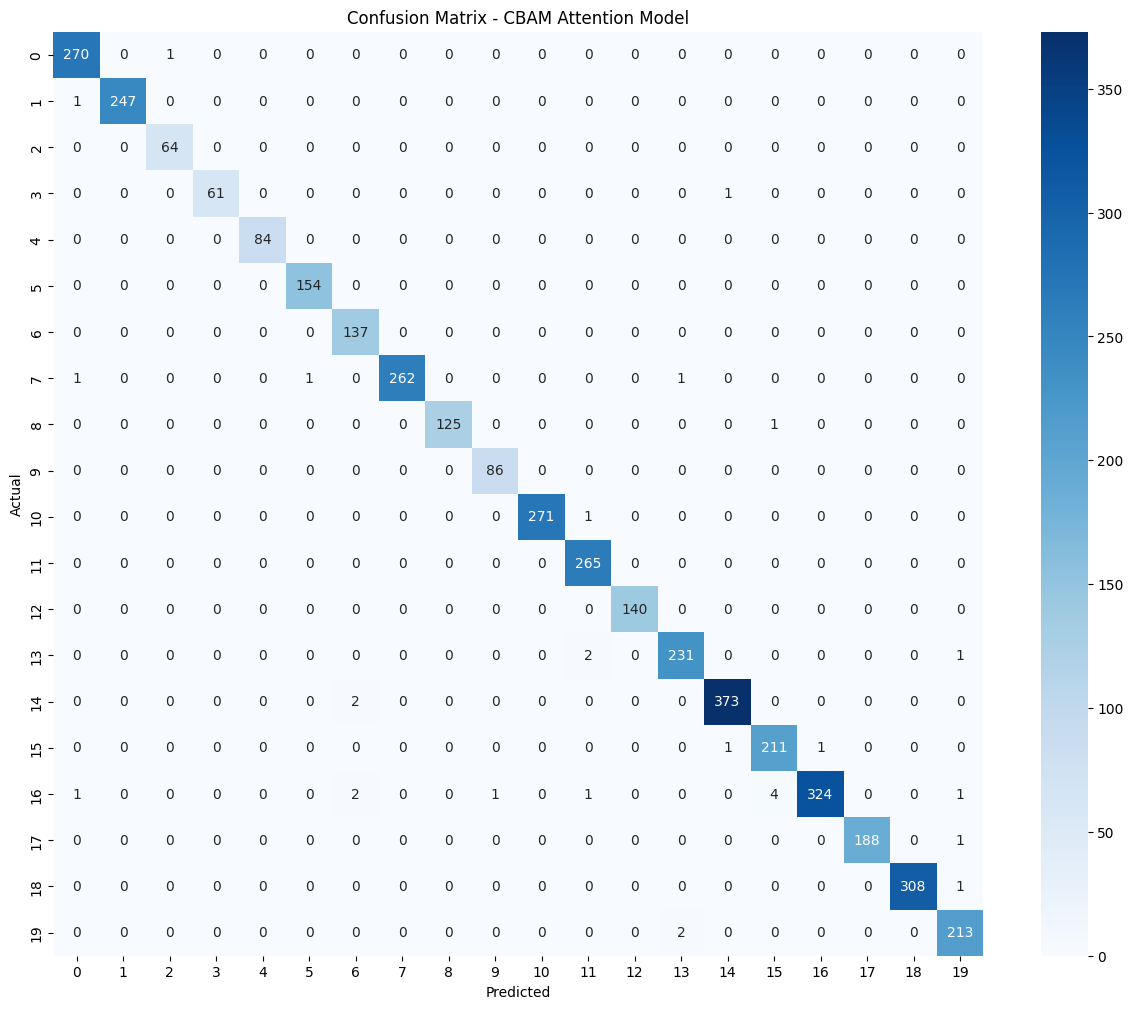


Classification Report for CBAM Attention Model:
              precision    recall  f1-score   support

     Class_0       0.99      1.00      0.99       271
     Class_1       1.00      1.00      1.00       248
     Class_2       0.98      1.00      0.99        64
     Class_3       1.00      0.98      0.99        62
     Class_4       1.00      1.00      1.00        84
     Class_5       0.99      1.00      1.00       154
     Class_6       0.97      1.00      0.99       137
     Class_7       1.00      0.99      0.99       265
     Class_8       1.00      0.99      1.00       126
     Class_9       0.99      1.00      0.99        86
    Class_10       1.00      1.00      1.00       272
    Class_11       0.99      1.00      0.99       265
    Class_12       1.00      1.00      1.00       140
    Class_13       0.99      0.99      0.99       234
    Class_14       0.99      0.99      0.99       375
    Class_15       0.98      0.99      0.98       213
    Class_16       1.00      0.9

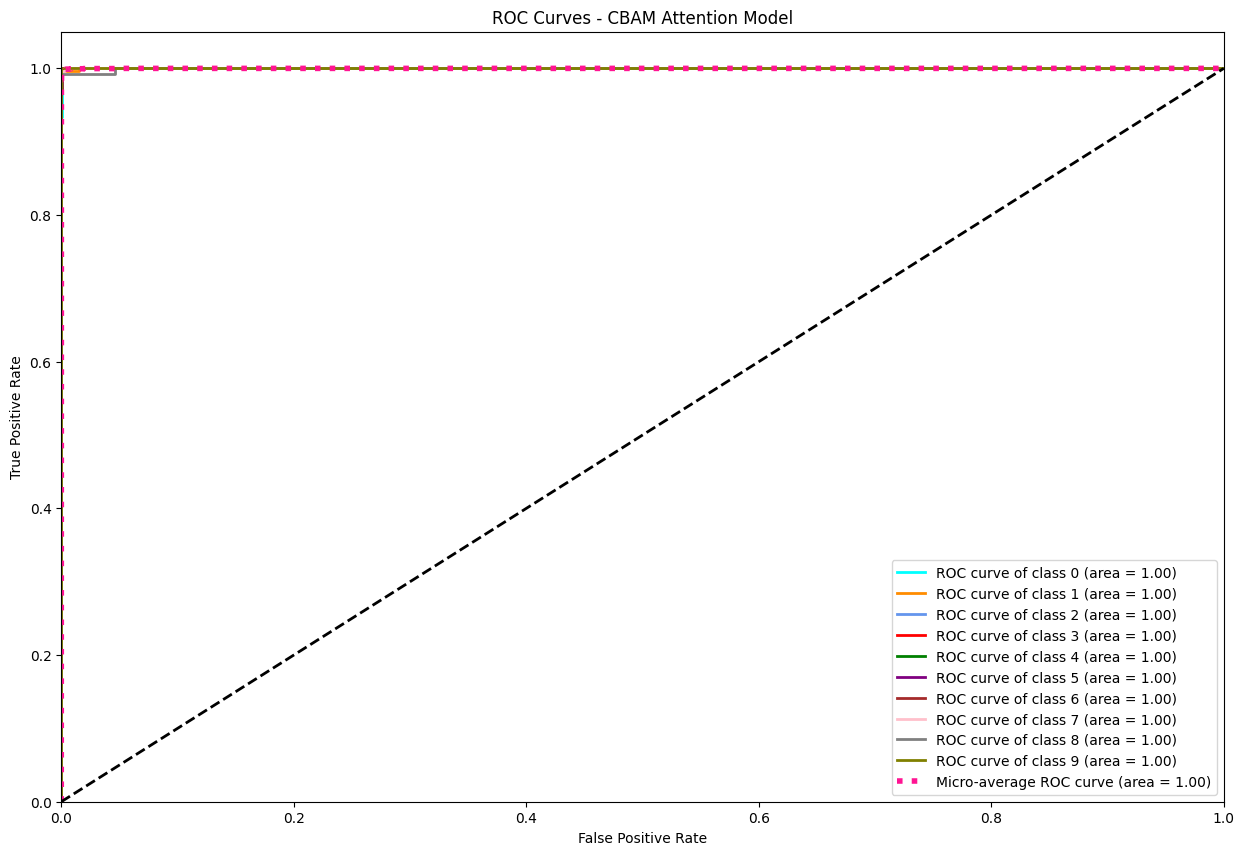


SUMMARY OF IMPROVEMENTS
Baseline CNN Accuracy: 0.9785
Best Attention (CBAM) CNN Accuracy: 0.9928
Improvement: 0.0143 (1.46%)

Final Comparison Results:
                 Model  Accuracy Precision    Recall  F1-Score   ROC-AUC  \
0         Baseline CNN    0.9785    0.9789    0.9785    0.9785    0.9996   
1               SE CNN    0.9889       N/A       N/A       N/A       N/A   
2               SE+SVM    0.9891  0.989222  0.989117  0.989125  0.999938   
3               SE+KNN    0.9894  0.989475  0.989364  0.989374  0.996721   
4     SE+Random Forest    0.9881  0.988231  0.988128  0.988137  0.999928   
5           SE+XGBoost    0.9819  0.982112  0.981944  0.981957  0.999414   
6             CBAM CNN    0.9928       N/A       N/A       N/A       N/A   
7             CBAM+SVM    0.9926  0.992668   0.99258  0.992586  0.999964   
8             CBAM+KNN    0.9921  0.992195  0.992085  0.992095  0.997005   
9   CBAM+Random Forest    0.9928  0.992894  0.992827  0.992833   0.99996   
10        C

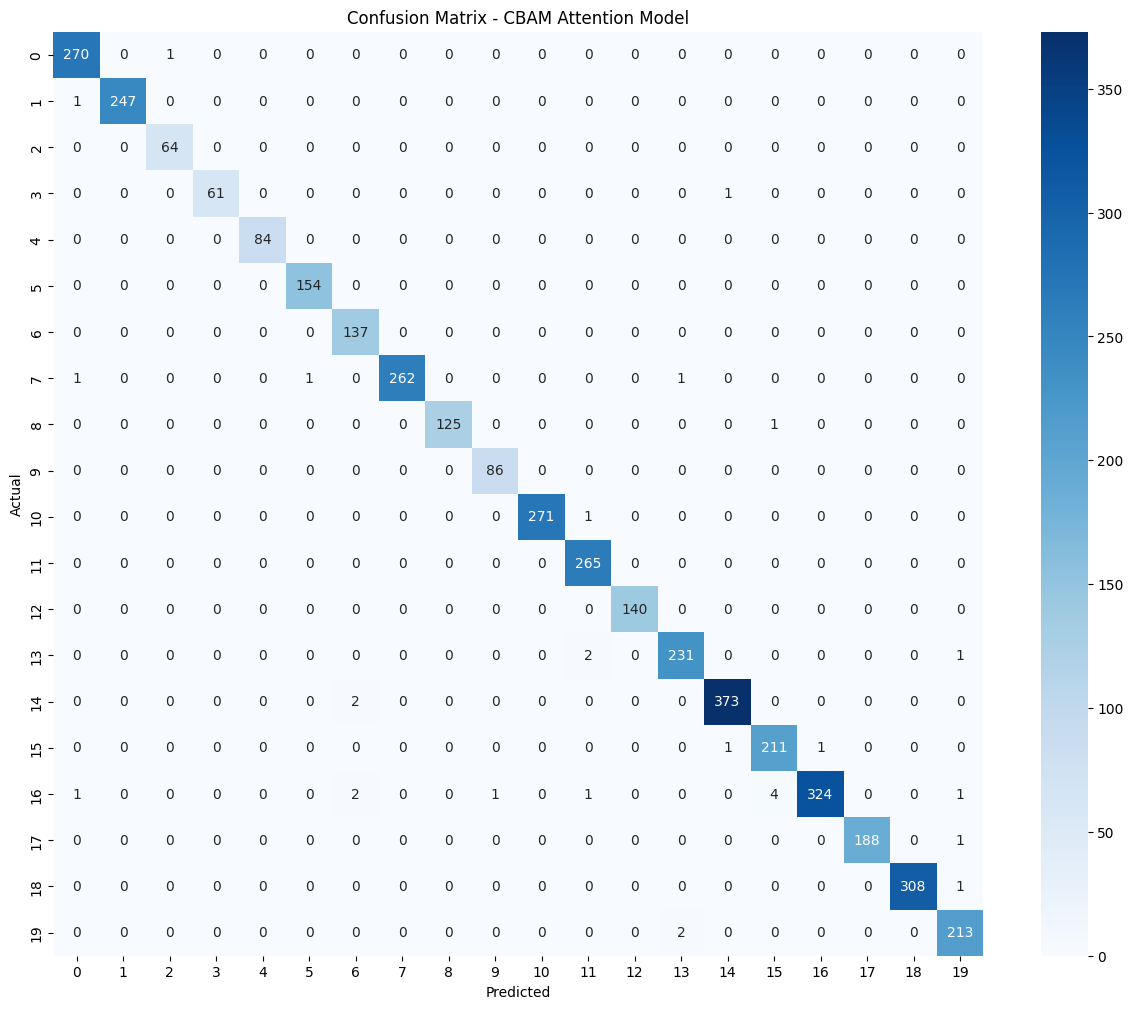


Classification Report for CBAM Attention Model:
              precision    recall  f1-score   support

     Class_0       0.99      1.00      0.99       271
     Class_1       1.00      1.00      1.00       248
     Class_2       0.98      1.00      0.99        64
     Class_3       1.00      0.98      0.99        62
     Class_4       1.00      1.00      1.00        84
     Class_5       0.99      1.00      1.00       154
     Class_6       0.97      1.00      0.99       137
     Class_7       1.00      0.99      0.99       265
     Class_8       1.00      0.99      1.00       126
     Class_9       0.99      1.00      0.99        86
    Class_10       1.00      1.00      1.00       272
    Class_11       0.99      1.00      0.99       265
    Class_12       1.00      1.00      1.00       140
    Class_13       0.99      0.99      0.99       234
    Class_14       0.99      0.99      0.99       375
    Class_15       0.98      0.99      0.98       213
    Class_16       1.00      0.9

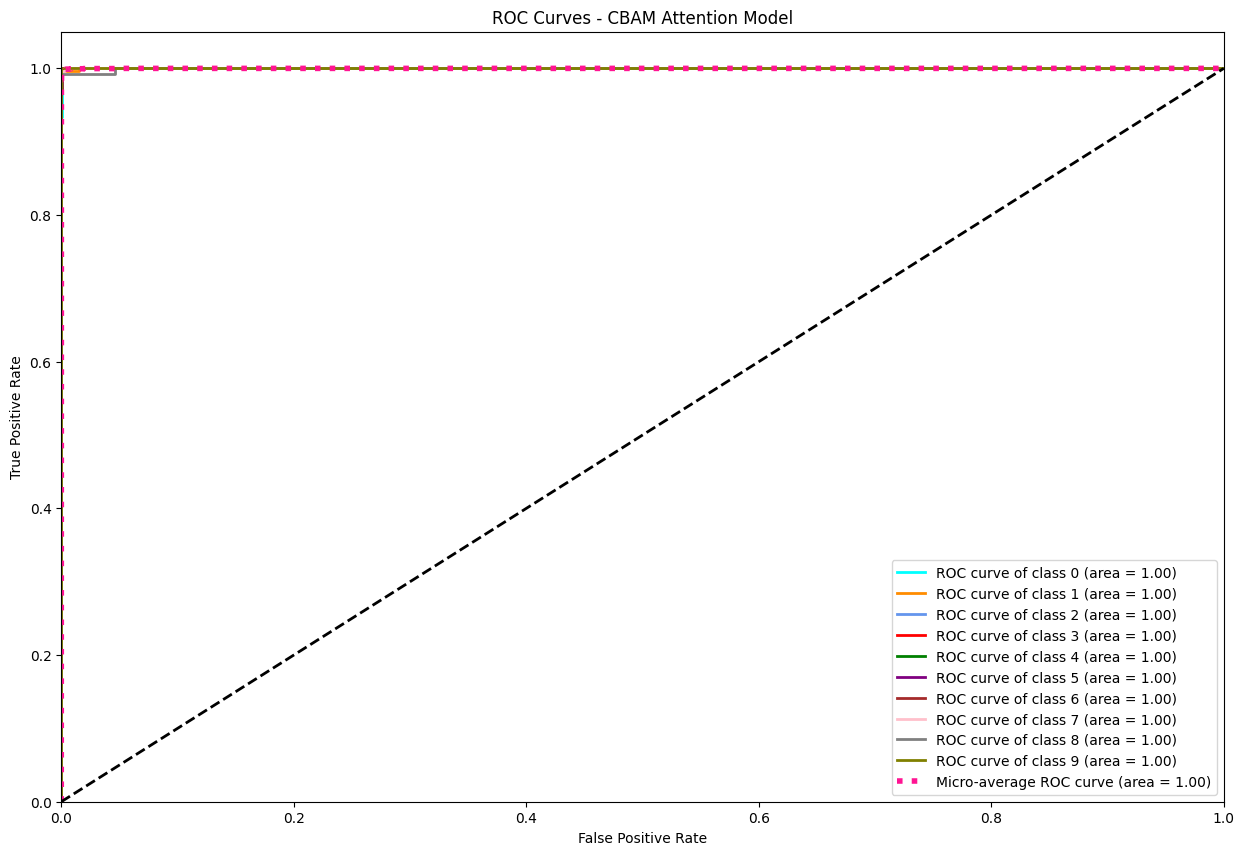


SUMMARY OF IMPROVEMENTS
Baseline CNN Accuracy: 0.9785
Best Attention (CBAM) CNN Accuracy: 0.9928
Improvement: 0.0143 (1.46%)


In [21]:

# Create final comparison DataFrame
comparison_df = pd.DataFrame(all_results)
print("\nFinal Comparison Results:")
print(comparison_df.round(4))

# Save comparison results
comparison_df.to_excel('/kaggle/working/comparison_results.xlsx', index=False)

# Detailed evaluation for the best attention model
best_attention_type = max(attention_results.keys(), key=lambda k: attention_results[k]['test_accuracy'])
print(f"\nDetailed Evaluation for Best Attention Model: {best_attention_type.upper()}")

# Load best attention model
best_model = attention_results[best_attention_type]['model']

# Class accuracy for best attention model
class_acc_attn = class_accuracy(best_model, dataloader_test_dataset, 20)
print("\nClass-wise Accuracy for Best Attention Model:")
for i in range(20):
    print(f"Class {i} Accuracy: {class_acc_attn[i]:.4f}")

print(f"\nAttention-based models implementation completed successfully!")
print(f"All results saved to /kaggle/working/comparison_results.xlsx")
# Classification report for best attention model
y_true_attn = []
y_pred_attn = []

best_model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true_attn.extend(labels.cpu().numpy())
        y_pred_attn.extend(predicted.cpu().numpy())

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true_attn, y_pred_attn)
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_attention_type.upper()} Attention Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(f'/kaggle/working/confusion_matrix_{best_attention_type}.png')
plt.show()

# Classification Report
class_names = [f"Class_{i}" for i in range(20)]
print(f"\nClassification Report for {best_attention_type.upper()} Attention Model:")
print(classification_report(y_true_attn, y_pred_attn, target_names=class_names))

# ROC Curve (for multi-class)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarize the output for ROC curve
y_test_binarized = label_binarize(y_true_attn, classes=range(20))
n_classes = y_test_binarized.shape[1]

# Get probabilities from the best attention model
y_proba_attn = []
best_model.eval()
with torch.no_grad():
    for inputs, _ in dataloader_test_dataset:
        inputs = inputs.to(device)
        outputs = best_model(inputs)
        probs = torch.softmax(outputs, dim=1)
        y_proba_attn.extend(probs.cpu().numpy())

y_proba_attn = np.array(y_proba_attn)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba_attn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_proba_attn.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(15, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive',
                'cyan', 'magenta', 'yellow', 'black', 'lime', 'teal', 'lavender', 'maroon', 'navy', 'gold'])

for i, color in zip(range(min(10, n_classes)), colors):  # Plot first 10 classes for clarity
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves - {best_attention_type.upper()} Attention Model')
plt.legend(loc="lower right")
plt.savefig(f'/kaggle/working/roc_curves_{best_attention_type}.png')
plt.show()

# Summary of improvements
print("\n" + "="*80)
print("SUMMARY OF IMPROVEMENTS")
print("="*80)

baseline_acc = 0.9785
best_attention_acc = attention_results[best_attention_type]['test_accuracy']

print(f"Baseline CNN Accuracy: {baseline_acc:.4f}")
print(f"Best Attention ({best_attention_type.upper()}) CNN Accuracy: {best_attention_acc:.4f}")
print(f"Improvement: {best_attention_acc - baseline_acc:.4f} ({((best_attention_acc - baseline_acc)/baseline_acc)*100:.2f}%)")

# Create final comparison DataFrame
comparison_df = pd.DataFrame(all_results)
print("\nFinal Comparison Results:")
print(comparison_df.round(4))

# Save comparison results
comparison_df.to_excel('/kaggle/working/comparison_results.xlsx', index=False)

# Detailed evaluation for the best attention model
best_attention_type = max(attention_results.keys(), key=lambda k: attention_results[k]['test_accuracy'])
print(f"\nDetailed Evaluation for Best Attention Model: {best_attention_type.upper()}")

# Load best attention model
best_model = attention_results[best_attention_type]['model']

# Class accuracy for best attention model
class_acc_attn = class_accuracy(best_model, dataloader_test_dataset, 20)
print("\nClass-wise Accuracy for Best Attention Model:")
for i in range(20):
    print(f"Class {i} Accuracy: {class_acc_attn[i]:.4f}")

print(f"\nAttention-based models implementation completed successfully!")
print(f"All results saved to /kaggle/working/comparison_results.xlsx")
# Classification report for best attention model
y_true_attn = []
y_pred_attn = []

best_model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true_attn.extend(labels.cpu().numpy())
        y_pred_attn.extend(predicted.cpu().numpy())

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true_attn, y_pred_attn)
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_attention_type.upper()} Attention Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(f'/kaggle/working/confusion_matrix_{best_attention_type}.png')
plt.show()

# Classification Report
class_names = [f"Class_{i}" for i in range(20)]
print(f"\nClassification Report for {best_attention_type.upper()} Attention Model:")
print(classification_report(y_true_attn, y_pred_attn, target_names=class_names))

# ROC Curve (for multi-class)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarize the output for ROC curve
y_test_binarized = label_binarize(y_true_attn, classes=range(20))
n_classes = y_test_binarized.shape[1]

# Get probabilities from the best attention model
y_proba_attn = []
best_model.eval()
with torch.no_grad():
    for inputs, _ in dataloader_test_dataset:
        inputs = inputs.to(device)
        outputs = best_model(inputs)
        probs = torch.softmax(outputs, dim=1)
        y_proba_attn.extend(probs.cpu().numpy())

y_proba_attn = np.array(y_proba_attn)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba_attn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_proba_attn.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(15, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive',
                'cyan', 'magenta', 'yellow', 'black', 'lime', 'teal', 'lavender', 'maroon', 'navy', 'gold'])

for i, color in zip(range(min(10, n_classes)), colors):  # Plot first 10 classes for clarity
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves - {best_attention_type.upper()} Attention Model')
plt.legend(loc="lower right")
plt.savefig(f'/kaggle/working/roc_curves_{best_attention_type}.png')
plt.show()

# Summary of improvements
print("\n" + "="*80)
print("SUMMARY OF IMPROVEMENTS")
print("="*80)

baseline_acc = 0.9785
best_attention_acc = attention_results[best_attention_type]['test_accuracy']

print(f"Baseline CNN Accuracy: {baseline_acc:.4f}")
print(f"Best Attention ({best_attention_type.upper()}) CNN Accuracy: {best_attention_acc:.4f}")
print(f"Improvement: {best_attention_acc - baseline_acc:.4f} ({((best_attention_acc - baseline_acc)/baseline_acc)*100:.2f}%)")



Performance Comparison of Attention Mechanisms:
  Attention Type  Test Accuracy  Training Time (min)  Test Time (sec)
0             SE         0.9889             237.6068          36.7884
1           CBAM         0.9928             235.5794          33.4799
2             GC         0.9881             232.4612          22.2276

All results have been saved to Excel files:
- /kaggle/working/comparison_results.xlsx
- /kaggle/working/attention_performance_comparison.xlsx
- /kaggle/working/confusion_matrix_cbam.png
- /kaggle/working/roc_curves_cbam.png


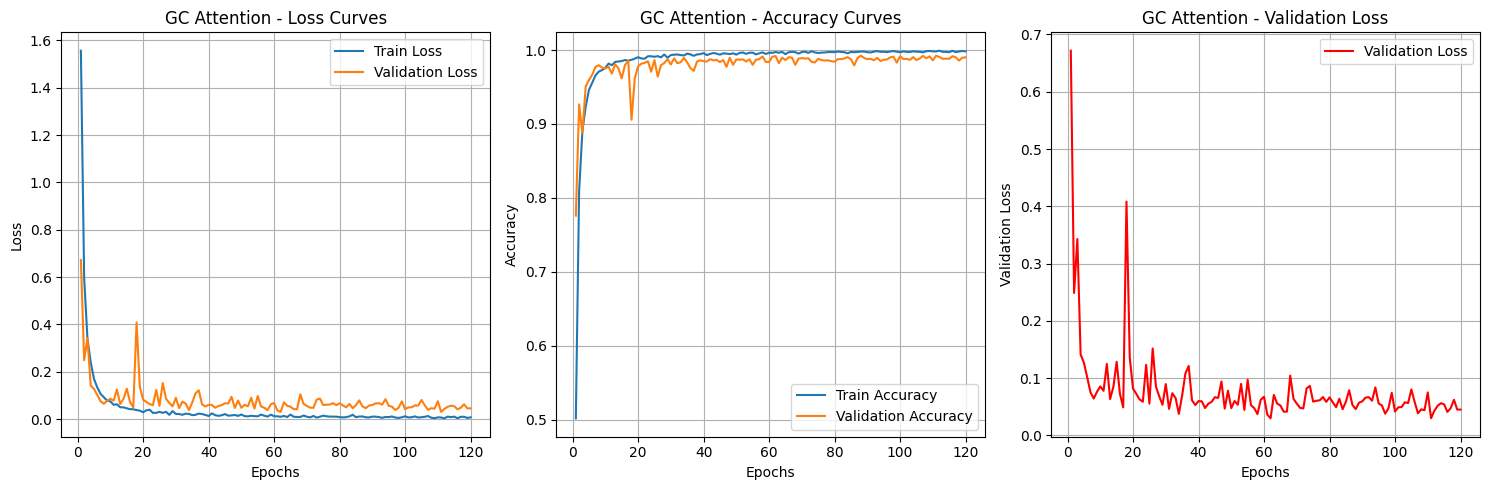


Training curves saved for all attention mechanisms.


In [22]:
# Performance comparison table
performance_comparison = []
for attn_type in attention_types:
    performance_comparison.append({
        'Attention Type': attn_type.upper(),
        'Test Accuracy': attention_results[attn_type]['test_accuracy'],
        'Training Time (min)': attention_results[attn_type]['training_time']/60,
        'Test Time (sec)': attention_results[attn_type]['test_time']
    })

perf_df = pd.DataFrame(performance_comparison)
print("\nPerformance Comparison of Attention Mechanisms:")
print(perf_df.round(4))

# Save performance comparison
perf_df.to_excel('/kaggle/working/attention_performance_comparison.xlsx', index=False)

print(f"\nAll results have been saved to Excel files:")
print(f"- /kaggle/working/comparison_results.xlsx")
print(f"- /kaggle/working/attention_performance_comparison.xlsx")
print(f"- /kaggle/working/confusion_matrix_{best_attention_type}.png")
print(f"- /kaggle/working/roc_curves_{best_attention_type}.png")

# Training curves for attention models
for attention_type in attention_types:
    try:
        history_attn = pd.read_excel(f'/kaggle/working/training_data_{attention_type}.xlsx')
        
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.plot(history_attn['Epoch'], history_attn['Train Loss'], label='Train Loss')
        plt.plot(history_attn['Epoch'], history_attn['Validation Loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'{attention_type.upper()} Attention - Loss Curves')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 3, 2)
        plt.plot(history_attn['Epoch'], history_attn['Train Accuracy'], label='Train Accuracy')
        plt.plot(history_attn['Epoch'], history_attn['Validation Accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'{attention_type.upper()} Attention - Accuracy Curves')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 3, 3)
        plt.plot(history_attn['Epoch'], history_attn['Validation Loss'], 'r-', label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Validation Loss')
        plt.title(f'{attention_type.upper()} Attention - Validation Loss')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig(f'/kaggle/working/training_curves_{attention_type}.png')
        plt.show()
    except Exception as e:
        print(f"Could not plot training curves for {attention_type}: {e}")

print("\nTraining curves saved for all attention mechanisms.")